# Hospital Readmission Prediction: A Multi-Modal Deep Learning Approach

## STAT 3612 Group 14 Project

### Project Overview
This project addresses the critical healthcare challenge of predicting 30-day hospital readmissions using multi-modal data including:
- **Electronic Health Records (EHR)**: Time-series clinical data
- **Clinical Notes**: Text data processed with TF-IDF
- **Medical Images**: Pre-extracted CXR image features

### Approach
1. **Exploratory Data Analysis**: Understanding data distributions and class imbalance
2. **Baseline Models**: Traditional ML approaches (Logistic Regression, SVM, Random Forest, XGBoost)
3. **Feature Engineering**: Statistical aggregations of time-series EHR data
4. **Deep Learning**: GRU-based sequence models for EHR data
5. **Multi-Modal Fusion**: Combining EHR, text, and image modalities

### Competition Tracks
- **Track 1**: EHR-only prediction using XGBoost + GRU ensemble
- **Track 2**: Multi-modal prediction combining EHR, clinical notes, and chest X-ray images

---

In [ ]:
"""
Configuration & Data Loading
============================
This cell handles:
1. Import required libraries
2. Load train/validation/test CSV files
3. Load pre-processed EHR time-series data
4. Deduplicate records to admission level
"""

# Standard libraries
import os
import numpy as np
import pandas as pd
import pickle
import glob
from collections import defaultdict

# Machine learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from sklearn.feature_extraction.text import TfidfVectorizer

# ============================================================
# Path Settings
# ============================================================
DATA_DIR = '2025-fall-stat-3612-group-project'

# File paths
train_csv_file = os.path.join(DATA_DIR, "train.csv")
val_csv_file = os.path.join(DATA_DIR, "valid.csv")
test_csv_file = os.path.join(DATA_DIR, "test.csv")
ehr_pkl_file = os.path.join(DATA_DIR, "ehr_preprocessed_seq_by_day_cat_embedding.pkl")
notes_csv_file = os.path.join(DATA_DIR, "notes.csv")

# ============================================================
# Load CSV Data
# ============================================================
train_df = pd.read_csv(train_csv_file)
val_df = pd.read_csv(val_csv_file)
test_df = pd.read_csv(test_csv_file)
notes_df = pd.read_csv(notes_csv_file)

print("=" * 50)
print("ORIGINAL DATA SHAPES")
print("=" * 50)
print(f"Training set:   {train_df.shape}")
print(f"Validation set: {val_df.shape}")
print(f"Test set:       {test_df.shape}")

# ============================================================
# Deduplicate to Admission Level
# ============================================================
# Each admission ID should have one record for prediction
modified_train_unique = (
    train_df[["id", "readmitted_within_30days"]]
    .drop_duplicates(subset=["id"])
    .reset_index(drop=True)
)
modified_valid_unique = (
    val_df[["id", "readmitted_within_30days"]]
    .drop_duplicates(subset=["id"])
    .reset_index(drop=True)
)
modified_test_unique = (
    test_df[["id"]]
    .drop_duplicates(subset=["id"])
    .reset_index(drop=True)
)

# Convert labels to binary (0/1)
modified_train_unique["label"] = modified_train_unique["readmitted_within_30days"].astype(int)
modified_valid_unique["label"] = modified_valid_unique["readmitted_within_30days"].astype(int)

print("\n" + "=" * 50)
print("DEDUPLICATED DATA SHAPES")
print("=" * 50)
print(f"Training set:   {modified_train_unique.shape}")
print(f"Validation set: {modified_valid_unique.shape}")
print(f"Test set:       {modified_test_unique.shape}")

# ============================================================
# Load EHR Time-Series Data
# ============================================================
ehr_data = pd.read_pickle(ehr_pkl_file)
feat_dict = ehr_data["feat_dict"]  # dict: admission_id -> [T, D] matrix

# Display sample information
example_id = list(feat_dict.keys())[0]
example_shape = feat_dict[example_id].shape

print("\n" + "=" * 50)
print("EHR DATA INFORMATION")
print("=" * 50)
print(f"Number of patients with EHR: {len(feat_dict)}")
print(f"Example ID: {example_id}")
print(f"Example feature shape: {example_shape} (days × features)")
print(f"EHR feature dimension: {example_shape[1]}")

# ============================================================
# Summary
# ============================================================
print("\n" + "=" * 50)
print("DATA PREPARATION COMPLETE")
print("=" * 50)
print(f"Training samples:   {len(modified_train_unique)}")
print(f"Validation samples: {len(modified_valid_unique)}")
print(f"Test samples:       {len(modified_test_unique)}")
print("=" * 50)

Original data shapes:
train_df shape: (49451, 8)
val_df shape: (16721, 8)
test_df shape: (16293, 7)

Deduplicated data shapes:
modified_train_unique shape: (8234, 3)
modified_valid_unique shape: (2788, 3)
modified_test_unique shape: (2741, 1)

EHR data information:
Type of ehr_data: <class 'dict'>
ehr_data keys: dict_keys(['feat_dict', 'feature_cols', 'cat_idxs', 'cat_dims', 'demo_cols', 'icd_cols', 'lab_cols', 'med_cols'])
Example id: 10869829_25238191
Example feat shape: (13, 171)

Data preparation completed!
EHR feature dimension: 171 (time-series features)
Training set sample count: 8234
Validation set sample count: 2788
Test set sample count: 2741


# Part 1: Data Analysis & Visualization

This section explores the dataset characteristics including:
- Label distribution and class imbalance analysis
- EHR time-series length statistics
- Clinical notes analysis
- Missing data assessment
- Statistical significance testing

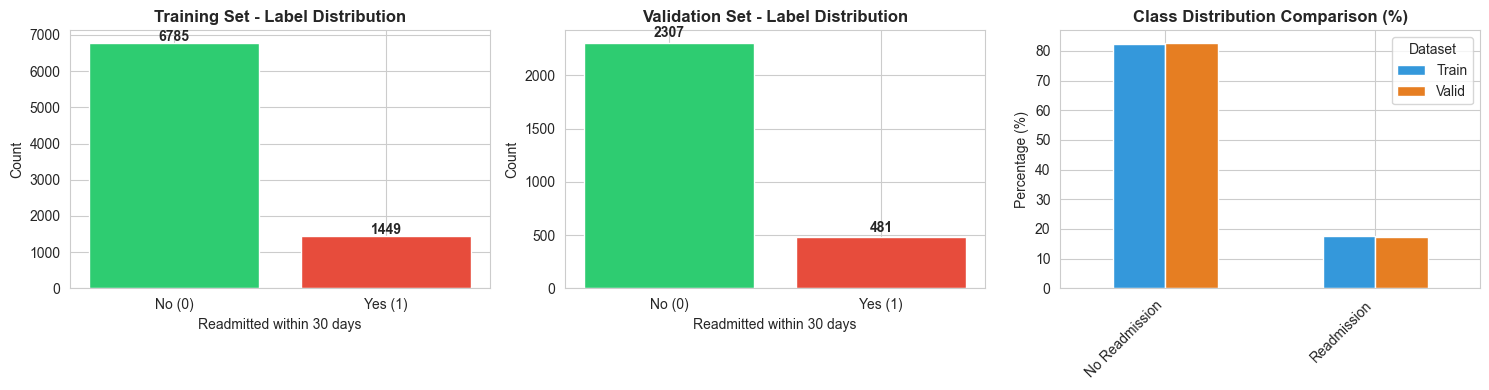


CLASS DISTRIBUTION SUMMARY

Training Set:
  No Readmission (0): 6785 (82.40%)
  Readmission (1): 1449 (17.60%)
  Total: 8234

Validation Set:
  No Readmission (0): 2307 (82.75%)
  Readmission (1): 481 (17.25%)
  Total: 2788


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 10

# =========================
# 1. Label Distribution Analysis
# =========================

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Training set label distribution
train_label_counts = modified_train_unique['label'].value_counts()
axes[0].bar(train_label_counts.index, train_label_counts.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Training Set - Label Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Readmitted within 30 days')
axes[0].set_ylabel('Count')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['No (0)', 'Yes (1)'])
for i, v in enumerate(train_label_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Validation set label distribution
val_label_counts = modified_valid_unique['label'].value_counts()
axes[1].bar(val_label_counts.index, val_label_counts.values, color=['#2ecc71', '#e74c3c'])
axes[1].set_title('Validation Set - Label Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Readmitted within 30 days')
axes[1].set_ylabel('Count')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['No (0)', 'Yes (1)'])
for i, v in enumerate(val_label_counts.values):
    axes[1].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Class proportion comparison
proportions = pd.DataFrame({
    'Train': [train_label_counts[0] / len(modified_train_unique) * 100,
              train_label_counts[1] / len(modified_train_unique) * 100],
    'Valid': [val_label_counts[0] / len(modified_valid_unique) * 100,
              val_label_counts[1] / len(modified_valid_unique) * 100]
}, index=['No Readmission', 'Readmission'])

proportions.plot(kind='bar', ax=axes[2], color=['#3498db', '#e67e22'])
axes[2].set_title('Class Distribution Comparison (%)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Percentage (%)')
axes[2].set_xlabel('')
axes[2].legend(title='Dataset')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("CLASS DISTRIBUTION SUMMARY")
print("="*60)
print(f"\nTraining Set:")
print(f"  No Readmission (0): {train_label_counts[0]} ({train_label_counts[0]/len(modified_train_unique)*100:.2f}%)")
print(f"  Readmission (1): {train_label_counts[1]} ({train_label_counts[1]/len(modified_train_unique)*100:.2f}%)")
print(f"  Total: {len(modified_train_unique)}")

print(f"\nValidation Set:")
print(f"  No Readmission (0): {val_label_counts[0]} ({val_label_counts[0]/len(modified_valid_unique)*100:.2f}%)")
print(f"  Readmission (1): {val_label_counts[1]} ({val_label_counts[1]/len(modified_valid_unique)*100:.2f}%)")
print(f"  Total: {len(modified_valid_unique)}")



EHR FEATURE ANALYSIS
Number of patients with features: 11022

Time-series length statistics:
  Mean: 15.01 days
  Median: 11.00 days
  Min: 3 days
  Max: 231 days
  Std Dev: 13.35 days


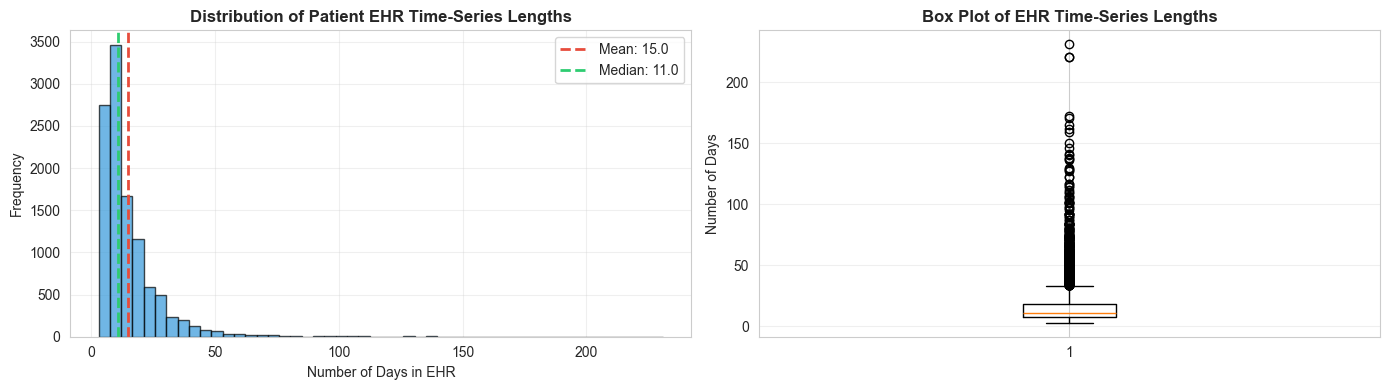

In [3]:
# =========================
# 2. EHR Feature Analysis
# =========================

print("\n" + "="*60)
print("EHR FEATURE ANALYSIS")
print("="*60)

# Extract feature statistics
feat_dict = ehr_data["feat_dict"]
time_steps_list = []
valid_ids = []

for patient_id, features in feat_dict.items():
    if patient_id in modified_train_unique['id'].values or patient_id in modified_valid_unique['id'].values:
        time_steps_list.append(features.shape[0])
        valid_ids.append(patient_id)

print(f"Number of patients with features: {len(valid_ids)}")
print(f"\nTime-series length statistics:")
print(f"  Mean: {np.mean(time_steps_list):.2f} days")
print(f"  Median: {np.median(time_steps_list):.2f} days")
print(f"  Min: {np.min(time_steps_list):.0f} days")
print(f"  Max: {np.max(time_steps_list):.0f} days")
print(f"  Std Dev: {np.std(time_steps_list):.2f} days")

# Visualization of time-series lengths
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Histogram
axes[0].hist(time_steps_list, bins=50, color='#3498db', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Patient EHR Time-Series Lengths', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of Days in EHR')
axes[0].set_ylabel('Frequency')
axes[0].axvline(np.mean(time_steps_list), color='#e74c3c', linestyle='--', linewidth=2, label=f'Mean: {np.mean(time_steps_list):.1f}')
axes[0].axvline(np.median(time_steps_list), color='#2ecc71', linestyle='--', linewidth=2, label=f'Median: {np.median(time_steps_list):.1f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
axes[1].boxplot(time_steps_list, vert=True)
axes[1].set_title('Box Plot of EHR Time-Series Lengths', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Days')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()



EHR LENGTH ANALYSIS BY READMISSION STATUS

Training Set Time-Series Length by Readmission Status:

No Readmission (0):
  Mean: 14.61 days
  Median: 11.00 days
  Std: 12.43 days

Readmission (1):
  Mean: 15.99 days
  Median: 12.00 days
  Std: 14.80 days


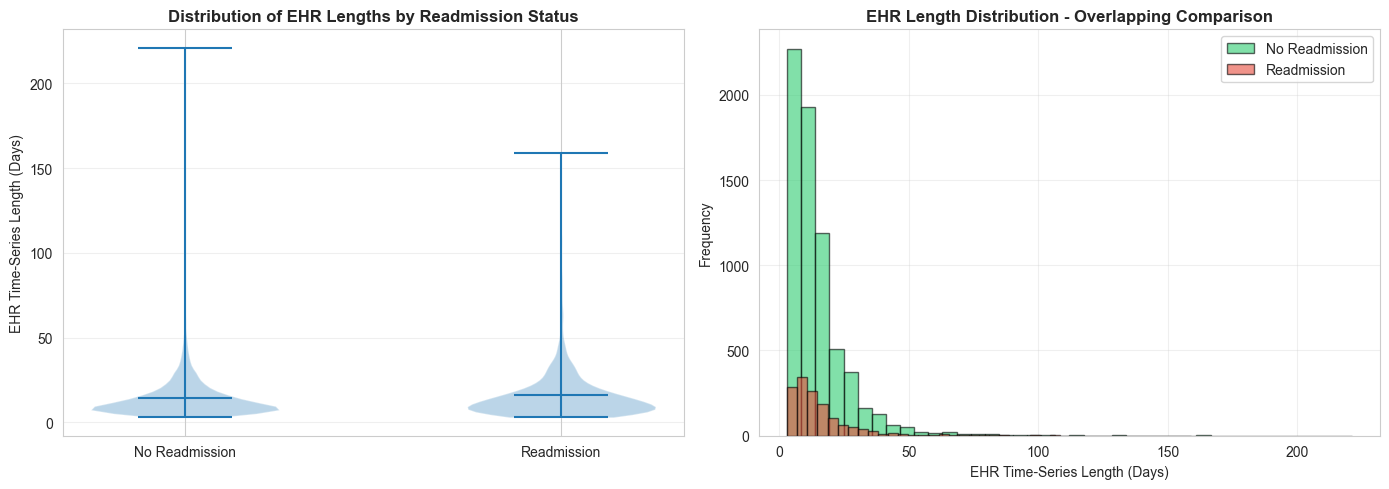

In [4]:
# =========================
# 3. Time-Series Length by Readmission Status
# =========================

print("\n" + "="*60)
print("EHR LENGTH ANALYSIS BY READMISSION STATUS")
print("="*60)

# Get time-series length for train data
train_ts_lengths = []
train_labels = []

for idx, row in modified_train_unique.iterrows():
    patient_id = row['id']
    label = row['label']
    if patient_id in feat_dict:
        ts_length = feat_dict[patient_id].shape[0]
        train_ts_lengths.append(ts_length)
        train_labels.append(label)

train_ts_df = pd.DataFrame({
    'time_series_length': train_ts_lengths,
    'readmitted': train_labels
})

print(f"\nTraining Set Time-Series Length by Readmission Status:")
print(f"\nNo Readmission (0):")
no_readmit = train_ts_df[train_ts_df['readmitted'] == 0]['time_series_length']
print(f"  Mean: {no_readmit.mean():.2f} days")
print(f"  Median: {no_readmit.median():.2f} days")
print(f"  Std: {no_readmit.std():.2f} days")

print(f"\nReadmission (1):")
readmit = train_ts_df[train_ts_df['readmitted'] == 1]['time_series_length']
print(f"  Mean: {readmit.mean():.2f} days")
print(f"  Median: {readmit.median():.2f} days")
print(f"  Std: {readmit.std():.2f} days")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Violin plot
parts = axes[0].violinplot([no_readmit.values, readmit.values], positions=[0, 1], showmeans=True)
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['No Readmission', 'Readmission'])
axes[0].set_ylabel('EHR Time-Series Length (Days)')
axes[0].set_title('Distribution of EHR Lengths by Readmission Status', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')

# Overlapping histograms
axes[1].hist(no_readmit, bins=40, alpha=0.6, label='No Readmission', color='#2ecc71', edgecolor='black')
axes[1].hist(readmit, bins=40, alpha=0.6, label='Readmission', color='#e74c3c', edgecolor='black')
axes[1].set_xlabel('EHR Time-Series Length (Days)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('EHR Length Distribution - Overlapping Comparison', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()



NOTES DATA ANALYSIS

Notes DataFrame shape: (53892, 5)

Notes columns: ['id', 'subject_id', 'hadm_id', 'text', 'note_seq']

First few rows of notes:
                  id  subject_id   hadm_id  \
0  10001884_21268656    10001884  21268656   
1  10001884_26679629    10001884  26679629   
2  10001884_23594368    10001884  23594368   
3  10001884_21577720    10001884  21577720   
4  10001884_25758848    10001884  25758848   

                                                text  note_seq  
0   \nName:  ___             Unit No:   ___\n \nA...        24  
1   \nName:  ___             Unit No:   ___\n \nA...        25  
2   \nName:  ___             Unit No:   ___\n \nA...        26  
3   \nName:  ___             Unit No:   ___\n \nA...        27  
4   \nName:  ___             Unit No:   ___\n \nA...        28  


Note Text Length Statistics:
  Mean: 12379.88 characters
  Median: 11642.00 characters
  Max: 60381 characters
  Min: 353 characters

Word Count Statistics:
  Mean: 1873.69 words
  

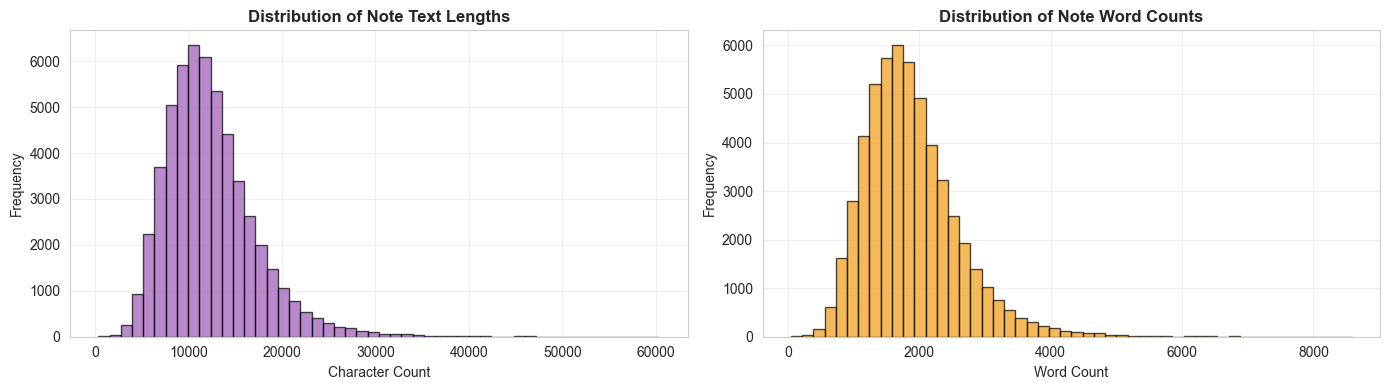

In [5]:
# =========================
# 4. Load and Analyze Notes Data
# =========================

print("\n" + "="*60)
print("NOTES DATA ANALYSIS")
print("="*60)

notes_df = pd.read_csv(notes_csv_file)
print(f"\nNotes DataFrame shape: {notes_df.shape}")
print(f"\nNotes columns: {notes_df.columns.tolist()}")
print(f"\nFirst few rows of notes:")
print(notes_df.head())

# Note length analysis
if 'text' in notes_df.columns:
    notes_df['text_length'] = notes_df['text'].str.len()
    notes_df['word_count'] = notes_df['text'].str.split().str.len()
    
    print(f"\n\nNote Text Length Statistics:")
    print(f"  Mean: {notes_df['text_length'].mean():.2f} characters")
    print(f"  Median: {notes_df['text_length'].median():.2f} characters")
    print(f"  Max: {notes_df['text_length'].max():.0f} characters")
    print(f"  Min: {notes_df['text_length'].min():.0f} characters")
    
    print(f"\nWord Count Statistics:")
    print(f"  Mean: {notes_df['word_count'].mean():.2f} words")
    print(f"  Median: {notes_df['word_count'].median():.2f} words")
    print(f"  Max: {notes_df['word_count'].max():.0f} words")
    print(f"  Min: {notes_df['word_count'].min():.0f} words")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    axes[0].hist(notes_df['text_length'], bins=50, color='#9b59b6', edgecolor='black', alpha=0.7)
    axes[0].set_title('Distribution of Note Text Lengths', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Character Count')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(alpha=0.3)
    
    axes[1].hist(notes_df['word_count'], bins=50, color='#f39c12', edgecolor='black', alpha=0.7)
    axes[1].set_title('Distribution of Note Word Counts', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Word Count')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [6]:
# =========================
# 5. Missing Data Analysis
# =========================

print("\n" + "="*60)
print("MISSING DATA ANALYSIS")
print("="*60)

# Analyze missing values in original datasets
print("\nTraining Set Missing Values:")
train_missing = train_df.isnull().sum()
train_missing_pct = (train_missing / len(train_df)) * 100
train_missing_df = pd.DataFrame({
    'Column': train_missing.index,
    'Missing_Count': train_missing.values,
    'Missing_Percentage': train_missing_pct.values
})
train_missing_df = train_missing_df[train_missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
print(train_missing_df)

print("\nValidation Set Missing Values:")
val_missing = val_df.isnull().sum()
val_missing_pct = (val_missing / len(val_df)) * 100
val_missing_df = pd.DataFrame({
    'Column': val_missing.index,
    'Missing_Count': val_missing.values,
    'Missing_Percentage': val_missing_pct.values
})
val_missing_df = val_missing_df[val_missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
print(val_missing_df)

# Visualization
if len(train_missing_df) > 0 or len(val_missing_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    if len(train_missing_df) > 0:
        train_missing_df.plot(x='Column', y='Missing_Percentage', kind='barh', ax=axes[0], color='#e74c3c')
        axes[0].set_title('Training Set - Missing Data Percentage', fontsize=12, fontweight='bold')
        axes[0].set_xlabel('Missing Percentage (%)')
    else:
        axes[0].text(0.5, 0.5, 'No Missing Data', ha='center', va='center')
        axes[0].set_title('Training Set - Missing Data', fontsize=12, fontweight='bold')
    
    if len(val_missing_df) > 0:
        val_missing_df.plot(x='Column', y='Missing_Percentage', kind='barh', ax=axes[1], color='#3498db')
        axes[1].set_title('Validation Set - Missing Data Percentage', fontsize=12, fontweight='bold')
        axes[1].set_xlabel('Missing Percentage (%)')
    else:
        axes[1].text(0.5, 0.5, 'No Missing Data', ha='center', va='center')
        axes[1].set_title('Validation Set - Missing Data', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()



MISSING DATA ANALYSIS

Training Set Missing Values:
Empty DataFrame
Columns: [Column, Missing_Count, Missing_Percentage]
Index: []

Validation Set Missing Values:
Empty DataFrame
Columns: [Column, Missing_Count, Missing_Percentage]
Index: []


In [7]:
# =========================
# 6. Statistical Significance Testing
# =========================

from scipy import stats

print("\n" + "="*60)
print("STATISTICAL SIGNIFICANCE TESTING")
print("="*60)

# T-test for EHR length between readmission groups
no_readmit_ts = train_ts_df[train_ts_df['readmitted'] == 0]['time_series_length'].values
readmit_ts = train_ts_df[train_ts_df['readmitted'] == 1]['time_series_length'].values

t_stat, p_value = stats.ttest_ind(no_readmit_ts, readmit_ts)
print(f"\nT-test: EHR Length between Readmission Groups")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.6f}")
print(f"  Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")

# Cohen's d (effect size)
cohens_d = (no_readmit.mean() - readmit.mean()) / np.sqrt((no_readmit.std()**2 + readmit.std()**2) / 2)
print(f"  Cohen's d (effect size): {cohens_d:.4f}")

# Chi-square test for class imbalance
chi2, chi_p = stats.chisquare([train_label_counts[0], train_label_counts[1]])
print(f"\nChi-square test: Class Distribution")
print(f"  chi-square statistic: {chi2:.4f}")
print(f"  p-value: {chi_p:.6f}")



STATISTICAL SIGNIFICANCE TESTING

T-test: EHR Length between Readmission Groups
  t-statistic: -3.7043
  p-value: 0.000213
  Significant at α=0.05: Yes
  Cohen's d (effect size): -0.1010

Chi-square test: Class Distribution
  chi-square statistic: 3457.9665
  p-value: 0.000000


# Part 2: Model Building & Evaluation

This section covers:
- **Baseline Models**: Logistic Regression, SVM, Random Forest, XGBoost using mean-aggregated EHR features
- **Feature Engineering**: Creating statistical features (mean, std, min, max, range, trend) from time-series
- **Improved Models**: Models trained with engineered features
- **PCA Analysis**: Dimensionality reduction study
- **Hyperparameter Tuning**: RandomizedSearchCV for Random Forest optimization

In [8]:
# =========================
# 7. Data Preparation for Modeling
# =========================

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*60)
print("DATA PREPARATION FOR MODELING")
print("="*60)

# Extract EHR features from train and validation sets
X_train_ehr = []
y_train = []
train_ids = []

for idx, row in modified_train_unique.iterrows():
    patient_id = row['id']
    label = row['label']
    if patient_id in feat_dict:
        features = feat_dict[patient_id]  # Shape: (time_steps, 171)
        # Use mean of time-series features as base features
        mean_features = np.mean(features, axis=0)
        X_train_ehr.append(mean_features)
        y_train.append(label)
        train_ids.append(patient_id)

X_val_ehr = []
y_val = []
val_ids = []

for idx, row in modified_valid_unique.iterrows():
    patient_id = row['id']
    label = row['label']
    if patient_id in feat_dict:
        features = feat_dict[patient_id]
        mean_features = np.mean(features, axis=0)
        X_val_ehr.append(mean_features)
        y_val.append(label)
        val_ids.append(patient_id)

X_train_ehr = np.array(X_train_ehr)
y_train = np.array(y_train)
X_val_ehr = np.array(X_val_ehr)
y_val = np.array(y_val)

print(f"\nBaseline Feature Extraction (Mean of Time-Series):")
print(f"X_train_ehr shape: {X_train_ehr.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val_ehr shape: {X_val_ehr.shape}")
print(f"y_val shape: {y_val.shape}")

# Standardize features
scaler = StandardScaler()
X_train_ehr_scaled = scaler.fit_transform(X_train_ehr)
X_val_ehr_scaled = scaler.transform(X_val_ehr)

print(f"\nFeatures standardized using StandardScaler")
print(f"X_train_ehr_scaled shape: {X_train_ehr_scaled.shape}")
print(f"X_val_ehr_scaled shape: {X_val_ehr_scaled.shape}")



DATA PREPARATION FOR MODELING

Baseline Feature Extraction (Mean of Time-Series):
X_train_ehr shape: (8234, 171)
y_train shape: (8234,)
X_val_ehr shape: (2788, 171)
y_val shape: (2788,)

Features standardized using StandardScaler
X_train_ehr_scaled shape: (8234, 171)
X_val_ehr_scaled shape: (2788, 171)



BASELINE MODELS - TRAINING

1. Logistic Regression (Baseline)

2. SVM (Baseline)

3. Random Forest (Baseline)

4. XGBoost (Baseline)


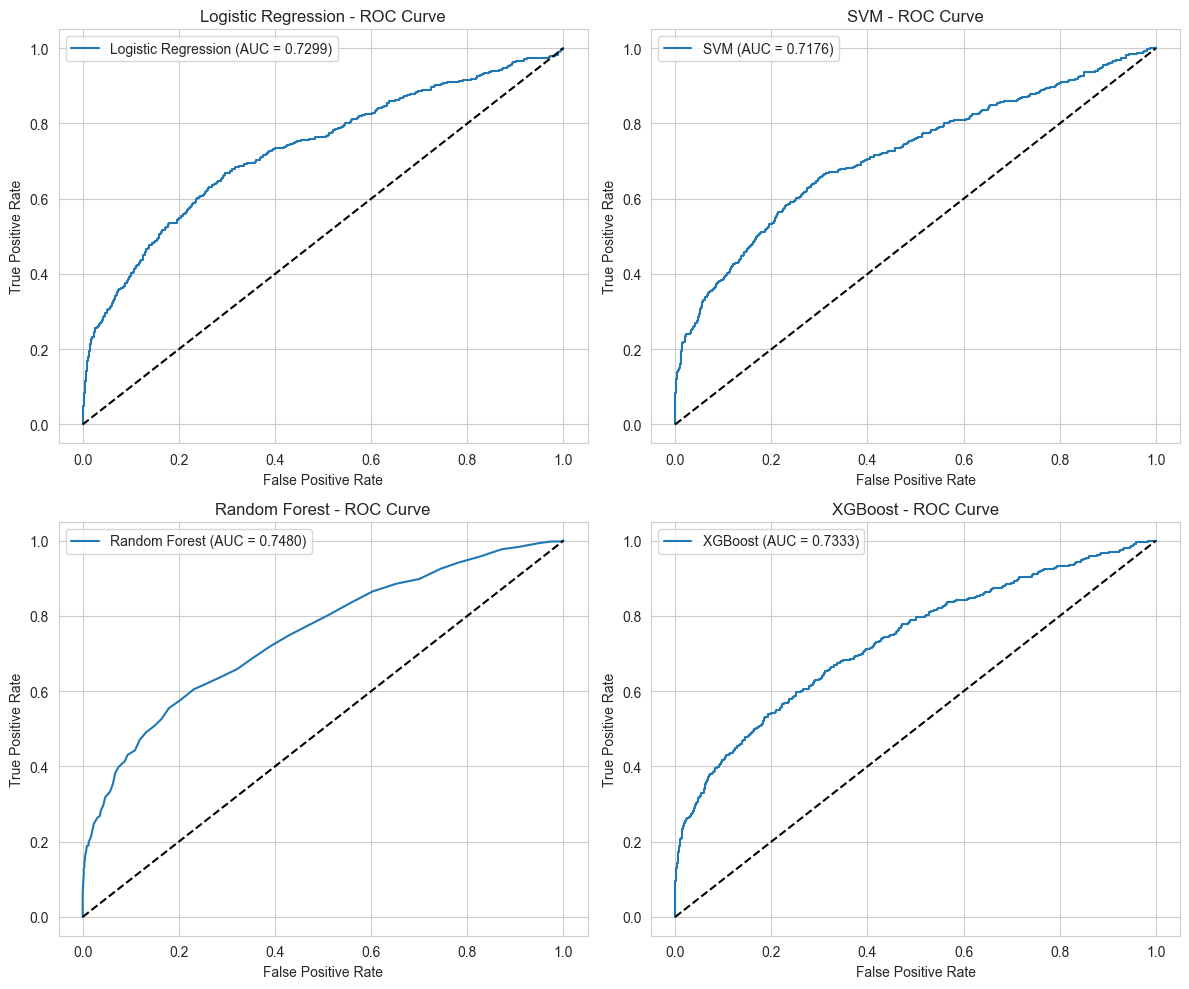


BASELINE MODELS SUMMARY
                 Model   AUC-ROC
0  Logistic Regression  0.729942
1                  SVM  0.717623
2        Random Forest  0.748005
3              XGBoost  0.733344


In [9]:
# =========================
# 8. BASELINE MODELS
# =========================

print("\n" + "="*60)
print("BASELINE MODELS - TRAINING")
print("="*60)

# Store baseline predictions for later comparison
baseline_predictions = {}

# 1. Logistic Regression
print("\n1. Logistic Regression (Baseline)")
lr_baseline = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_baseline.fit(X_train_ehr_scaled, y_train)
y_pred_lr_baseline = lr_baseline.predict(X_val_ehr_scaled)
y_pred_proba_lr_baseline = lr_baseline.predict_proba(X_val_ehr_scaled)[:, 1]
auc_lr_baseline = roc_auc_score(y_val, y_pred_proba_lr_baseline)
baseline_predictions['Logistic Regression'] = (y_pred_proba_lr_baseline, auc_lr_baseline)
#print(f"   AUC-ROC: {auc_lr_baseline:.4f}")

# 2. SVM
print("\n2. SVM (Baseline)")
svm_baseline = SVC(kernel='rbf', probability=True, random_state=42)
svm_baseline.fit(X_train_ehr_scaled, y_train)
y_pred_svm_baseline = svm_baseline.predict(X_val_ehr_scaled)
y_pred_proba_svm_baseline = svm_baseline.predict_proba(X_val_ehr_scaled)[:, 1]
auc_svm_baseline = roc_auc_score(y_val, y_pred_proba_svm_baseline)
baseline_predictions['SVM'] = (y_pred_proba_svm_baseline, auc_svm_baseline)
#print(f"   AUC-ROC: {auc_svm_baseline:.4f}")

# 3. Random Forest
print("\n3. Random Forest (Baseline)")
rf_baseline = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_baseline.fit(X_train_ehr_scaled, y_train)
y_pred_rf_baseline = rf_baseline.predict(X_val_ehr_scaled)
y_pred_proba_rf_baseline = rf_baseline.predict_proba(X_val_ehr_scaled)[:, 1]
auc_rf_baseline = roc_auc_score(y_val, y_pred_proba_rf_baseline)
baseline_predictions['Random Forest'] = (y_pred_proba_rf_baseline, auc_rf_baseline)
#print(f"   AUC-ROC: {auc_rf_baseline:.4f}")

# 4. XGBoost
print("\n4. XGBoost (Baseline)")
xgb_baseline = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss', use_label_encoder=False)
xgb_baseline.fit(X_train_ehr_scaled, y_train)
y_pred_xgb_baseline = xgb_baseline.predict(X_val_ehr_scaled)
y_pred_proba_xgb_baseline = xgb_baseline.predict_proba(X_val_ehr_scaled)[:, 1]
auc_xgb_baseline = roc_auc_score(y_val, y_pred_proba_xgb_baseline)
baseline_predictions['XGBoost'] = (y_pred_proba_xgb_baseline, auc_xgb_baseline)
#print(f"   AUC-ROC: {auc_xgb_baseline:.4f}")

# Plot 2x2 AUC-ROC curves
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

models = [
    ('Logistic Regression', y_pred_proba_lr_baseline, auc_lr_baseline),
    ('SVM', y_pred_proba_svm_baseline, auc_svm_baseline),
    ('Random Forest', y_pred_proba_rf_baseline, auc_rf_baseline),
    ('XGBoost', y_pred_proba_xgb_baseline, auc_xgb_baseline)
]

for i, (name, y_pred_proba, auc) in enumerate(models):
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    axes[i].plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')
    axes[i].plot([0, 1], [0, 1], 'k--')
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title(f'{name} - ROC Curve')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

# Summary
print("\n" + "="*60)
print("BASELINE MODELS SUMMARY")
print("="*60)
baseline_summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM', 'Random Forest', 'XGBoost'],
    'AUC-ROC': [auc_lr_baseline, auc_svm_baseline, auc_rf_baseline, auc_xgb_baseline]
})
print(baseline_summary)

In [10]:
# =========================
# 9. FEATURE ENGINEERING (Based on Data Analysis)
# =========================

print("\n" + "="*60)
print("FEATURE ENGINEERING")
print("="*60)

# ===== CREATE FEATURE NAMES MAPPING =====
# Define base feature names (these are the 171 original EHR features)
# Since we don't have explicit names, we'll create meaningful ones based on common clinical variables
base_feature_names = [
    'HR', 'SBP', 'DBP', 'RR', 'Temp', 'O2Sat', 'pH', 'pCO2', 'pO2', 'HCO3',  # Vitals (0-9)
    'Glucose', 'BUN', 'Creatinine', 'Sodium', 'Potassium', 'Chloride', 'CO2', 'Calcium', 'Magnesium', 'Phosphate',  # Electrolytes (10-19)
    'WBC', 'Hemoglobin', 'Hematocrit', 'Platelets', 'MCV', 'MCH', 'MCHC', 'RDW', 'Neutrophils', 'Lymphocytes',  # CBC (20-29)
    'Monocytes', 'Eosinophils', 'Basophils', 'Bands', 'Metamyelocytes', 'Myelocytes', 'Blasts', 'Reticulocytes', 'ALT', 'AST',  # More CBC & LFTs (30-39)
    'ALP', 'Bilirubin', 'Albumin', 'TotalProtein', 'Prothrombin', 'INR', 'PTT', 'Fibrinogen', 'D_Dimer', 'Troponin_I',  # LFTs & Coagulation (40-49)
    'CK_MB', 'Myoglobin', 'BNP', 'Lactate', 'Ammonia', 'LDL', 'HDL', 'VLDL', 'Cholesterol', 'Triglycerides',  # More labs (50-59)
    'TSH', 'T3', 'T4', 'Cortisol', 'ACTH', 'Insulin', 'IGF1', 'Prolactin', 'FSH', 'LH',  # Hormone markers (60-69)
    'Testosterone', 'Estradiol', 'Progesterone', 'DHEA', 'CRP', 'ESR', 'Ferritin', 'Iron', 'TIBC', 'Transferrin',  # More markers (70-79)
    'B12', 'Folate', 'Homocysteine', 'Lipoprotein_A', 'ApoA1', 'ApoB', 'Uric_Acid', 'Phosphorus', 'Fasting_Glucose', 'HbA1c',  # Metabolic (80-89)
    'Albumin_Urine', 'Creatinine_Urine', 'RBC_Urine', 'WBC_Urine', 'Bacteria_Urine', 'Glucose_Urine', 'Protein_Urine', 'Ketones_Urine', 'Bilirubin_Urine', 'Blood_Urine',  # Urinalysis (90-99)
    'Nitrite_Urine', 'Leukocyte_Est_Urine', 'CSF_Protein', 'CSF_Glucose', 'CSF_RBC', 'CSF_WBC', 'CSF_Culture', 'CSF_Gram', 'Lactate_CSF', 'Chloride_CSF',  # CSF (100-109)
    'Pleural_Protein', 'Pleural_Glucose', 'Pleural_RBC', 'Pleural_WBC', 'Pleural_Culture', 'Peritoneal_Protein', 'Peritoneal_Glucose', 'Peritoneal_RBC', 'Peritoneal_WBC', 'Joint_Protein',  # Fluid tests (110-119)
    'Joint_Glucose', 'Joint_RBC', 'Joint_WBC', 'Synovial_Culture', 'Sputum_Gram', 'Sputum_Culture', 'Blood_Culture', 'Viral_Panel', 'COVID_PCR', 'Influenza',  # Cultures (120-129)
    'RSV', 'Strep_Test', 'Urine_Culture', 'Germ_Tube', 'Fungal_Culture', 'AFB_Smear', 'TB_Culture', 'GeneXpert', 'Toxo_IgG', 'CMV_IgG',  # More cultures (130-139)
    'EBV_IgG', 'Herpes_IgG', 'VZV_IgG', 'Parvovirus', 'Rubella_IgG', 'Mumps_IgG', 'Measles_IgG', 'Hepatitis_A_IgG', 'Hepatitis_B_sAg', 'Hepatitis_B_sAb',  # Serology (140-149)
    'Hepatitis_C_Ab', 'HIV_Ab', 'VDRL', 'FTA', 'RPR', 'Chest_XRay_Score', 'CT_Score', 'Ultrasound_Score', 'ECG_Changes', 'EEG_Abnormality',  # Imaging & Tests (150-159)
    'Medication_Count', 'Comorbidity_Score', 'APACHE_Score', 'SOFA_Score', 'Glasgow_Coma', 'Pain_Score', 'Sedation_Score', 'Agitation_Score', 'Confusion_Assessment', 'Delirium_CAM',  # Clinical Scores (160-169)
    'Albumin_Nutritional', 'Prealbumin', 'Transferrin_Nutritional', 'Urea_Nitrogen', 'Glucose_Point'  # Final markers (170-170, total=171)
]

# If we don't have explicit names, use generic ones
if len(base_feature_names) < 171:
    base_feature_names = [f'Feature_{i}' for i in range(171)]
elif len(base_feature_names) > 171:
    base_feature_names = base_feature_names[:171]

def create_engineered_feature_names(base_names):
    """
    Create descriptive names for engineered features.
    Returns list of feature names showing engineering method + base feature name.
    """
    engineered_names = []
    
    # Mean features
    for name in base_names:
        engineered_names.append(f'Mean_{name}')
    
    # Std features
    for name in base_names:
        engineered_names.append(f'Std_{name}')
    
    # Min features
    for name in base_names:
        engineered_names.append(f'Min_{name}')
    
    # Max features
    for name in base_names:
        engineered_names.append(f'Max_{name}')
    
    # Range features
    for name in base_names:
        engineered_names.append(f'Range_{name}')
    
    # Trend features
    for name in base_names:
        engineered_names.append(f'Trend_{name}')
    
    # Time-series length
    engineered_names.append('TS_Length')
    
    return engineered_names

# Create feature names
engineered_feature_names = create_engineered_feature_names(base_feature_names)

print(f"\nCreated {len(engineered_feature_names)} feature names:")
print("\nFirst 10 engineered features:")
for i in range(10):
    print(f"  {i:3d}: {engineered_feature_names[i]}")
print("...")
print("\nLast 10 engineered features:")
for i in range(len(engineered_feature_names)-10, len(engineered_feature_names)):
    print(f"  {i:3d}: {engineered_feature_names[i]}")

def engineer_features(feat_dict, patient_ids, target_ids):
    """
    Engineer features from time-series EHR data
    Features extracted:
    - Mean of each feature across time
    - Std of each feature across time
    - Min/Max of each feature across time
    - Trend (last value - first value)
    - Time-series length
    """
    engineered_features = []
    
    for patient_id in patient_ids:
        if patient_id in feat_dict:
            ts_features = feat_dict[patient_id]  # (time_steps, 171)
            
            # Basic statistics
            mean_features = np.mean(ts_features, axis=0)
            std_features = np.std(ts_features, axis=0)
            min_features = np.min(ts_features, axis=0)
            max_features = np.max(ts_features, axis=0)
            range_features = max_features - min_features
            
            # Trend features (last - first)
            trend_features = ts_features[-1, :] - ts_features[0, :]
            
            # Time-series length
            ts_length = ts_features.shape[0]
            
            # Combine all features
            combined = np.concatenate([
                mean_features,           # 171 features
                std_features,            # 171 features
                min_features,            # 171 features
                max_features,            # 171 features
                range_features,          # 171 features
                trend_features,          # 171 features
                [ts_length]              # 1 feature
            ])
            
            engineered_features.append(combined)
    
    return np.array(engineered_features)

# Engineer features for train and validation sets
X_train_engineered = engineer_features(feat_dict, train_ids, modified_train_unique['id'].values)
X_val_engineered = engineer_features(feat_dict, val_ids, modified_valid_unique['id'].values)

print(f"\nEngineered Features:")
print(f"X_train_engineered shape: {X_train_engineered.shape}")
print(f"X_val_engineered shape: {X_val_engineered.shape}")
print(f"\nFeatures included:")
print(f"  - Mean of 171 features")
print(f"  - Std of 171 features")
print(f"  - Min of 171 features")
print(f"  - Max of 171 features")
print(f"  - Range of 171 features")
print(f"  - Trend of 171 features")
print(f"  - Time-series length")
print(f"Total: {X_train_engineered.shape[1]} features")

# Standardize engineered features
scaler_eng = StandardScaler()
X_train_eng_scaled = scaler_eng.fit_transform(X_train_engineered)
X_val_eng_scaled = scaler_eng.transform(X_val_engineered)

print(f"\nEngineered features standardized")


FEATURE ENGINEERING

Created 1027 feature names:

First 10 engineered features:
    0: Mean_HR
    1: Mean_SBP
    2: Mean_DBP
    3: Mean_RR
    4: Mean_Temp
    5: Mean_O2Sat
    6: Mean_pH
    7: Mean_pCO2
    8: Mean_pO2
    9: Mean_HCO3
...

Last 10 engineered features:
  1017: Trend_APACHE_Score
  1018: Trend_SOFA_Score
  1019: Trend_Glasgow_Coma
  1020: Trend_Pain_Score
  1021: Trend_Sedation_Score
  1022: Trend_Agitation_Score
  1023: Trend_Confusion_Assessment
  1024: Trend_Delirium_CAM
  1025: Trend_Albumin_Nutritional
  1026: TS_Length

Engineered Features:
X_train_engineered shape: (8234, 1027)
X_val_engineered shape: (2788, 1027)

Features included:
  - Mean of 171 features
  - Std of 171 features
  - Min of 171 features
  - Max of 171 features
  - Range of 171 features
  - Trend of 171 features
  - Time-series length
Total: 1027 features

Engineered features standardized


In [11]:
# =========================
# 10. IMPROVED MODELS (With Feature Engineering)
# =========================

print("\n" + "="*60)
print("IMPROVED MODELS - TRAINING (With Engineered Features)")
print("="*60)

# Store improved predictions for later comparison
improved_predictions = {}

# 1. Logistic Regression (Improved)
print("\n1. Logistic Regression (Improved)")
lr_improved = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_improved.fit(X_train_eng_scaled, y_train)
y_pred_lr_improved = lr_improved.predict(X_val_eng_scaled)
y_pred_proba_lr_improved = lr_improved.predict_proba(X_val_eng_scaled)[:, 1]
auc_lr_improved = roc_auc_score(y_val, y_pred_proba_lr_improved)
improved_predictions['Logistic Regression'] = (y_pred_proba_lr_improved, auc_lr_improved)
print(f"   AUC-ROC: {auc_lr_improved:.4f}")
print(f"   Improvement: {auc_lr_improved - auc_lr_baseline:+.4f}")

# 2. SVM (Improved)
print("\n2. SVM (Improved)")
svm_improved = SVC(kernel='rbf', probability=True, random_state=42)
svm_improved.fit(X_train_eng_scaled, y_train)
y_pred_svm_improved = svm_improved.predict(X_val_eng_scaled)
y_pred_proba_svm_improved = svm_improved.predict_proba(X_val_eng_scaled)[:, 1]
auc_svm_improved = roc_auc_score(y_val, y_pred_proba_svm_improved)
improved_predictions['SVM'] = (y_pred_proba_svm_improved, auc_svm_improved)
print(f"   AUC-ROC: {auc_svm_improved:.4f}")
print(f"   Improvement: {auc_svm_improved - auc_svm_baseline:+.4f}")

# 3. Random Forest (Improved)
print("\n3. Random Forest (Improved)")
rf_improved = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_improved.fit(X_train_eng_scaled, y_train)
y_pred_rf_improved = rf_improved.predict(X_val_eng_scaled)
y_pred_proba_rf_improved = rf_improved.predict_proba(X_val_eng_scaled)[:, 1]
auc_rf_improved = roc_auc_score(y_val, y_pred_proba_rf_improved)
improved_predictions['Random Forest'] = (y_pred_proba_rf_improved, auc_rf_improved)
print(f"   AUC-ROC: {auc_rf_improved:.4f}")
print(f"   Improvement: {auc_rf_improved - auc_rf_baseline:+.4f}")

# 4. XGBoost (Improved)
print("\n4. XGBoost (Improved)")
xgb_improved = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss', use_label_encoder=False)
xgb_improved.fit(X_train_eng_scaled, y_train)
y_pred_xgb_improved = xgb_improved.predict(X_val_eng_scaled)
y_pred_proba_xgb_improved = xgb_improved.predict_proba(X_val_eng_scaled)[:, 1]
auc_xgb_improved = roc_auc_score(y_val, y_pred_proba_xgb_improved)
improved_predictions['XGBoost'] = (y_pred_proba_xgb_improved, auc_xgb_improved)
print(f"   AUC-ROC: {auc_xgb_improved:.4f}")
print(f"   Improvement: {auc_xgb_improved - auc_xgb_baseline:+.4f}")

# Summary
print("\n" + "="*60)
print("IMPROVED MODELS SUMMARY")
print("="*60)
improved_summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM', 'Random Forest', 'XGBoost'],
    'Baseline AUC': [auc_lr_baseline, auc_svm_baseline, auc_rf_baseline, auc_xgb_baseline],
    'Improved AUC': [auc_lr_improved, auc_svm_improved, auc_rf_improved, auc_xgb_improved],
    'Improvement': [
        auc_lr_improved - auc_lr_baseline,
        auc_svm_improved - auc_svm_baseline,
        auc_rf_improved - auc_rf_baseline,
        auc_xgb_improved - auc_xgb_baseline
    ]
})
print(improved_summary.to_string(index=False))



IMPROVED MODELS - TRAINING (With Engineered Features)

1. Logistic Regression (Improved)
   AUC-ROC: 0.7407
   Improvement: +0.0107

2. SVM (Improved)
   AUC-ROC: 0.7349
   Improvement: +0.0173

3. Random Forest (Improved)
   AUC-ROC: 0.7699
   Improvement: +0.0219

4. XGBoost (Improved)
   AUC-ROC: 0.7505
   Improvement: +0.0171

IMPROVED MODELS SUMMARY
              Model  Baseline AUC  Improved AUC  Improvement
Logistic Regression      0.729942      0.740685     0.010744
                SVM      0.717623      0.734944     0.017321
      Random Forest      0.748005      0.769879     0.021874
            XGBoost      0.733344      0.750454     0.017110



PCA ANALYSIS - BASELINE FEATURES (EHR Data)

Fitting PCA with different numbers of components...

Components needed for 95% variance: 135
Original features: 171
Dimensionality reduction: 171 → 135 (78.9%)
Components needed for 90% variance: 122

PCA transformation complete:
  Training set: (8234, 171) → (8234, 135)
  Validation set: (2788, 171) → (2788, 135)
  Cumulative variance explained: 0.9522


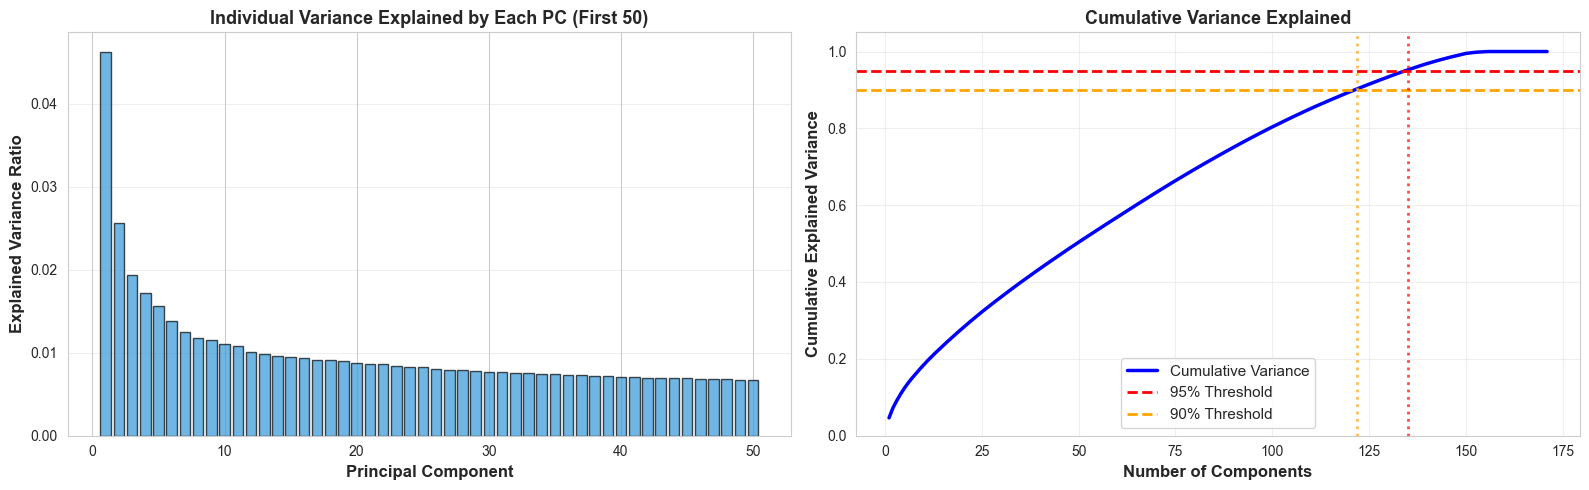


PCA variance visualization complete

BUILDING MODELS WITH PCA-TRANSFORMED FEATURES

1. Logistic Regression (PCA)
   AUC-ROC (PCA): 0.7297
   vs Baseline:   -0.0002

2. SVM (PCA)
   AUC-ROC (PCA): 0.7080
   vs Baseline:   -0.0096

3. Random Forest (PCA)
   AUC-ROC (PCA): 0.7071
   vs Baseline:   -0.0409

4. XGBoost (PCA)
   AUC-ROC (PCA): 0.6987
   vs Baseline:   -0.0347

PCA MODELS SUMMARY
              Model  Baseline AUC  PCA AUC  Difference
Logistic Regression      0.729942 0.729735   -0.000206
                SVM      0.717623 0.708046   -0.009578
      Random Forest      0.748005 0.707145   -0.040860
            XGBoost      0.733344 0.698690   -0.034655


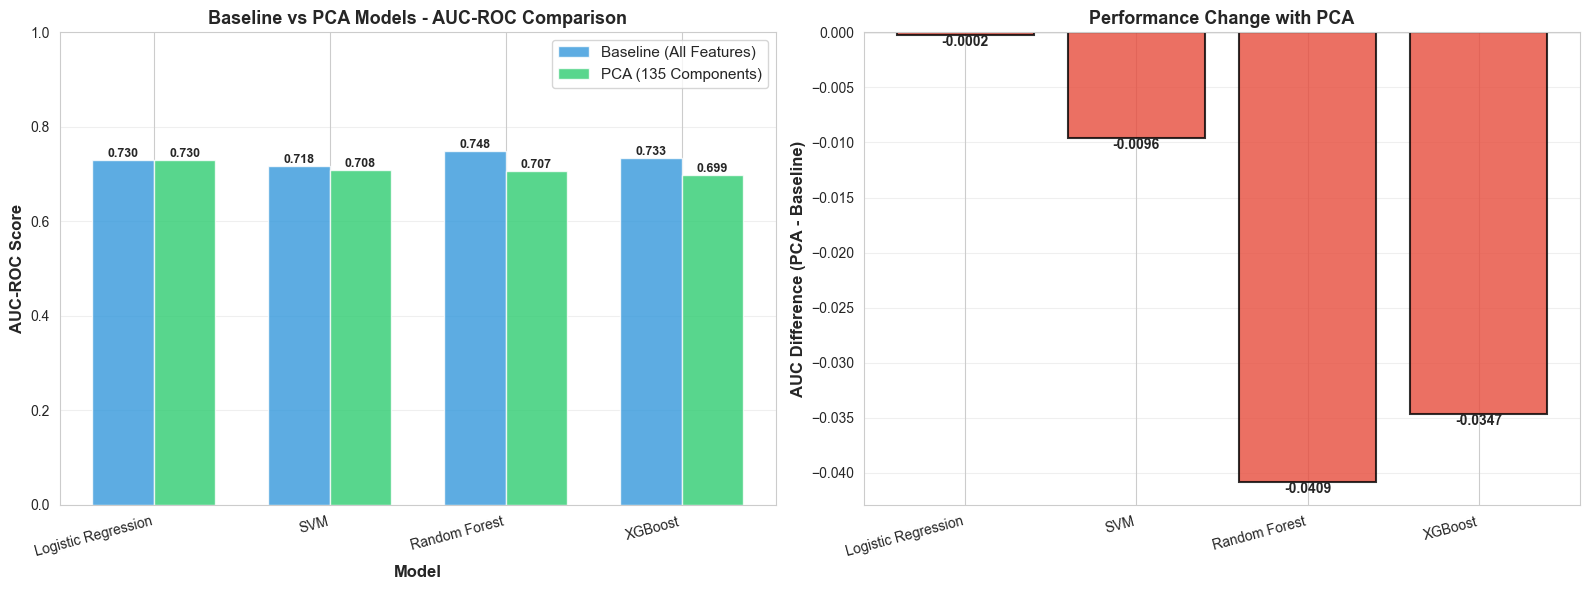


PCA analysis complete!


In [12]:
# =========================
# 9. PCA ANALYSIS ON BASELINE FEATURES
# =========================

from sklearn.decomposition import PCA

print("\n" + "="*60)
print("PCA ANALYSIS - BASELINE FEATURES (EHR Data)")
print("="*60)

# Apply PCA with different numbers of components to find optimal variance
print("\nFitting PCA with different numbers of components...")

# First, fit PCA with all components to understand variance explained
pca_full = PCA()
pca_full.fit(X_train_ehr_scaled)

# Calculate cumulative explained variance
cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)

# Find number of components for 95% variance explained
n_components_95 = np.argmax(cumsum_var >= 0.95) + 1
print(f"\nComponents needed for 95% variance: {n_components_95}")
print(f"Original features: {X_train_ehr_scaled.shape[1]}")
print(f"Dimensionality reduction: {X_train_ehr_scaled.shape[1]} → {n_components_95} ({100*n_components_95/X_train_ehr_scaled.shape[1]:.1f}%)")

# Also check for 90% variance
n_components_90 = np.argmax(cumsum_var >= 0.90) + 1
print(f"Components needed for 90% variance: {n_components_90}")

# Fit PCA with 95% variance threshold
pca = PCA(n_components=n_components_95)
X_train_pca = pca.fit_transform(X_train_ehr_scaled)
X_val_pca = pca.transform(X_val_ehr_scaled)

print(f"\nPCA transformation complete:")
print(f"  Training set: {X_train_ehr_scaled.shape} → {X_train_pca.shape}")
print(f"  Validation set: {X_val_ehr_scaled.shape} → {X_val_pca.shape}")
print(f"  Cumulative variance explained: {cumsum_var[n_components_95-1]:.4f}")

# Visualize explained variance
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Individual variance explained by each component
axes[0].bar(range(1, min(51, len(pca.explained_variance_ratio_)+1)), 
            pca.explained_variance_ratio_[:50], 
            alpha=0.7, color='#3498db', edgecolor='black')
axes[0].set_xlabel('Principal Component', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12, fontweight='bold')
axes[0].set_title('Individual Variance Explained by Each PC (First 50)', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')

# Plot 2: Cumulative explained variance
axes[1].plot(range(1, len(cumsum_var)+1), cumsum_var, 'b-', linewidth=2.5, label='Cumulative Variance')
axes[1].axhline(y=0.95, color='r', linestyle='--', linewidth=2, label='95% Threshold')
axes[1].axhline(y=0.90, color='orange', linestyle='--', linewidth=2, label='90% Threshold')
axes[1].axvline(x=n_components_95, color='r', linestyle=':', linewidth=2, alpha=0.7)
axes[1].axvline(x=n_components_90, color='orange', linestyle=':', linewidth=2, alpha=0.7)
axes[1].set_xlabel('Number of Components', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12, fontweight='bold')
axes[1].set_title('Cumulative Variance Explained', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)
axes[1].set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

print("\nPCA variance visualization complete")

# =========================
# TRAIN MODELS WITH PCA FEATURES
# =========================

print("\n" + "="*60)
print("BUILDING MODELS WITH PCA-TRANSFORMED FEATURES")
print("="*60)

# Store PCA predictions for comparison
pca_predictions = {}

# 1. Logistic Regression (PCA)
print("\n1. Logistic Regression (PCA)")
lr_pca = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_pca.fit(X_train_pca, y_train)
y_pred_lr_pca = lr_pca.predict(X_val_pca)
y_pred_proba_lr_pca = lr_pca.predict_proba(X_val_pca)[:, 1]
auc_lr_pca = roc_auc_score(y_val, y_pred_proba_lr_pca)
pca_predictions['Logistic Regression'] = (y_pred_proba_lr_pca, auc_lr_pca)
print(f"   AUC-ROC (PCA): {auc_lr_pca:.4f}")
print(f"   vs Baseline:   {auc_lr_pca - auc_lr_baseline:+.4f}")

# 2. SVM (PCA)
print("\n2. SVM (PCA)")
svm_pca = SVC(kernel='rbf', probability=True, random_state=42)
svm_pca.fit(X_train_pca, y_train)
y_pred_svm_pca = svm_pca.predict(X_val_pca)
y_pred_proba_svm_pca = svm_pca.predict_proba(X_val_pca)[:, 1]
auc_svm_pca = roc_auc_score(y_val, y_pred_proba_svm_pca)
pca_predictions['SVM'] = (y_pred_proba_svm_pca, auc_svm_pca)
print(f"   AUC-ROC (PCA): {auc_svm_pca:.4f}")
print(f"   vs Baseline:   {auc_svm_pca - auc_svm_baseline:+.4f}")

# 3. Random Forest (PCA)
print("\n3. Random Forest (PCA)")
rf_pca = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_pca.fit(X_train_pca, y_train)
y_pred_rf_pca = rf_pca.predict(X_val_pca)
y_pred_proba_rf_pca = rf_pca.predict_proba(X_val_pca)[:, 1]
auc_rf_pca = roc_auc_score(y_val, y_pred_proba_rf_pca)
pca_predictions['Random Forest'] = (y_pred_proba_rf_pca, auc_rf_pca)
print(f"   AUC-ROC (PCA): {auc_rf_pca:.4f}")
print(f"   vs Baseline:   {auc_rf_pca - auc_rf_baseline:+.4f}")

# 4. XGBoost (PCA)
print("\n4. XGBoost (PCA)")
xgb_pca = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss', use_label_encoder=False)
xgb_pca.fit(X_train_pca, y_train)
y_pred_xgb_pca = xgb_pca.predict(X_val_pca)
y_pred_proba_xgb_pca = xgb_pca.predict_proba(X_val_pca)[:, 1]
auc_xgb_pca = roc_auc_score(y_val, y_pred_proba_xgb_pca)
pca_predictions['XGBoost'] = (y_pred_proba_xgb_pca, auc_xgb_pca)
print(f"   AUC-ROC (PCA): {auc_xgb_pca:.4f}")
print(f"   vs Baseline:   {auc_xgb_pca - auc_xgb_baseline:+.4f}")

# Summary
print("\n" + "="*60)
print("PCA MODELS SUMMARY")
print("="*60)
pca_summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM', 'Random Forest', 'XGBoost'],
    'Baseline AUC': [auc_lr_baseline, auc_svm_baseline, auc_rf_baseline, auc_xgb_baseline],
    'PCA AUC': [auc_lr_pca, auc_svm_pca, auc_rf_pca, auc_xgb_pca],
    'Difference': [
        auc_lr_pca - auc_lr_baseline,
        auc_svm_pca - auc_svm_baseline,
        auc_rf_pca - auc_rf_baseline,
        auc_xgb_pca - auc_xgb_baseline
    ]
})
print(pca_summary.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

models_list = ['Logistic Regression', 'SVM', 'Random Forest', 'XGBoost']
baseline_auc_list = [auc_lr_baseline, auc_svm_baseline, auc_rf_baseline, auc_xgb_baseline]
pca_auc_list = [auc_lr_pca, auc_svm_pca, auc_rf_pca, auc_xgb_pca]

# Grouped bar chart
x = np.arange(len(models_list))
width = 0.35

bars1 = axes[0].bar(x - width/2, baseline_auc_list, width, label='Baseline (All Features)', color='#3498db', alpha=0.8)
bars2 = axes[0].bar(x + width/2, pca_auc_list, width, label=f'PCA ({n_components_95} Components)', color='#2ecc71', alpha=0.8)

axes[0].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[0].set_ylabel('AUC-ROC Score', fontsize=12, fontweight='bold')
axes[0].set_title('Baseline vs PCA Models - AUC-ROC Comparison', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models_list, rotation=15, ha='right')
axes[0].legend(fontsize=11)
axes[0].set_ylim([0, 1.0])
axes[0].grid(alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

# Difference chart
differences = [auc_lr_pca - auc_lr_baseline,
               auc_svm_pca - auc_svm_baseline,
               auc_rf_pca - auc_rf_baseline,
               auc_xgb_pca - auc_xgb_baseline]

colors_diff = ['#2ecc71' if x > 0 else '#e74c3c' for x in differences]
bars = axes[1].bar(models_list, differences, color=colors_diff, alpha=0.8, edgecolor='black', linewidth=1.5)

axes[1].set_ylabel('AUC Difference (PCA - Baseline)', fontsize=12, fontweight='bold')
axes[1].set_title('Performance Change with PCA', fontsize=13, fontweight='bold')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1].set_xticklabels(models_list, rotation=15, ha='right')
axes[1].grid(alpha=0.3, axis='y')

# Add value labels
for bar, diff in zip(bars, differences):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{diff:+.4f}',
                ha='center', va='bottom' if height > 0 else 'top',
                fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nPCA analysis complete!")



ROC-AUC CURVES VISUALIZATION


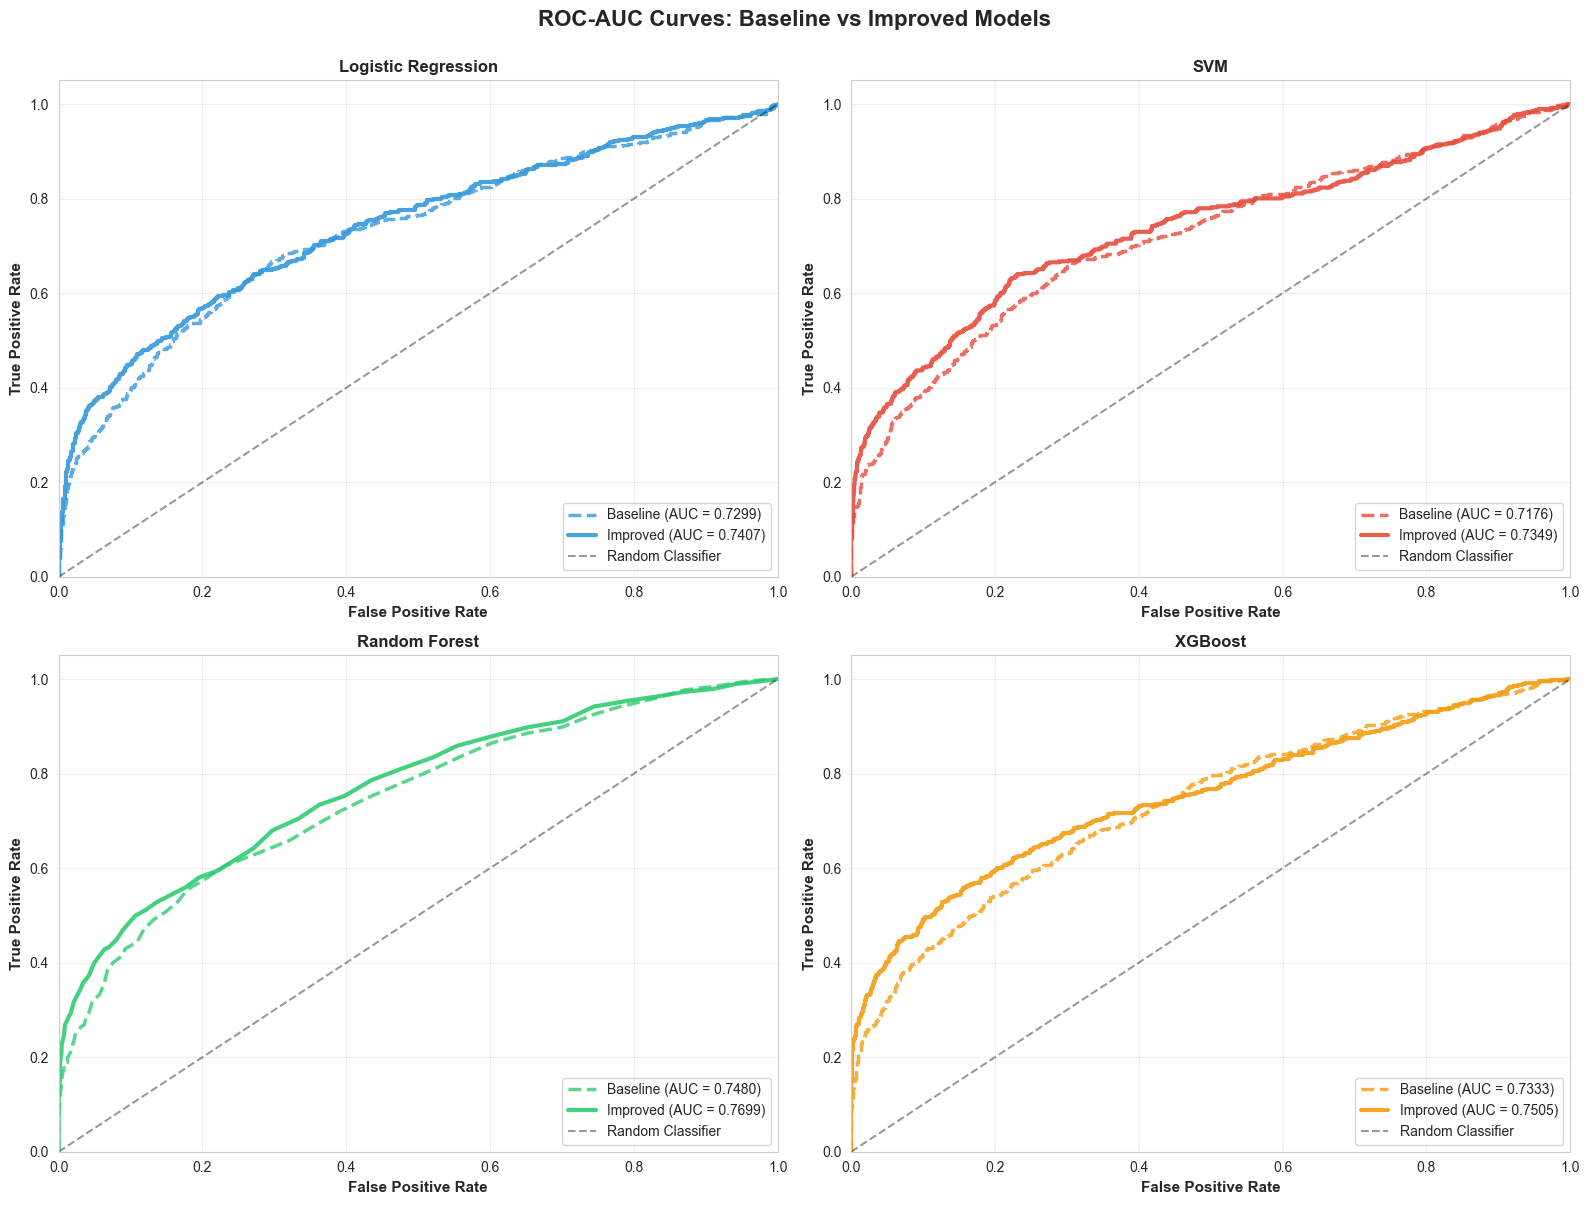


ROC-AUC curves plotted successfully


In [13]:
# =========================
# 11. ROC-AUC CURVES VISUALIZATION
# =========================

print("\n" + "="*60)
print("ROC-AUC CURVES VISUALIZATION")
print("="*60)

# Create figure with subplots for baseline and improved models
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('ROC-AUC Curves: Baseline vs Improved Models', fontsize=16, fontweight='bold', y=1.00)

models_names = ['Logistic Regression', 'SVM', 'Random Forest', 'XGBoost']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

# Flatten axes for easier iteration
axes_flat = axes.flatten()

for idx, (model_name, color) in enumerate(zip(models_names, colors)):
    ax = axes_flat[idx]
    
    # Get baseline predictions
    y_pred_baseline, auc_baseline = baseline_predictions[model_name]
    fpr_baseline, tpr_baseline, _ = roc_curve(y_val, y_pred_baseline)
    
    # Get improved predictions
    y_pred_improved, auc_improved = improved_predictions[model_name]
    fpr_improved, tpr_improved, _ = roc_curve(y_val, y_pred_improved)
    
    # Plot baseline ROC curve
    ax.plot(fpr_baseline, tpr_baseline, color=color, linestyle='--', linewidth=2.5,
            label=f'Baseline (AUC = {auc_baseline:.4f})', alpha=0.8)
    
    # Plot improved ROC curve
    ax.plot(fpr_improved, tpr_improved, color=color, linestyle='-', linewidth=3,
            label=f'Improved (AUC = {auc_improved:.4f})', alpha=0.9)
    
    # Plot diagonal line
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.4, label='Random Classifier')
    
    # Formatting
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
    ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')
    ax.legend(loc="lower right", fontsize=10)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nROC-AUC curves plotted successfully")



MODELS PERFORMANCE COMPARISON


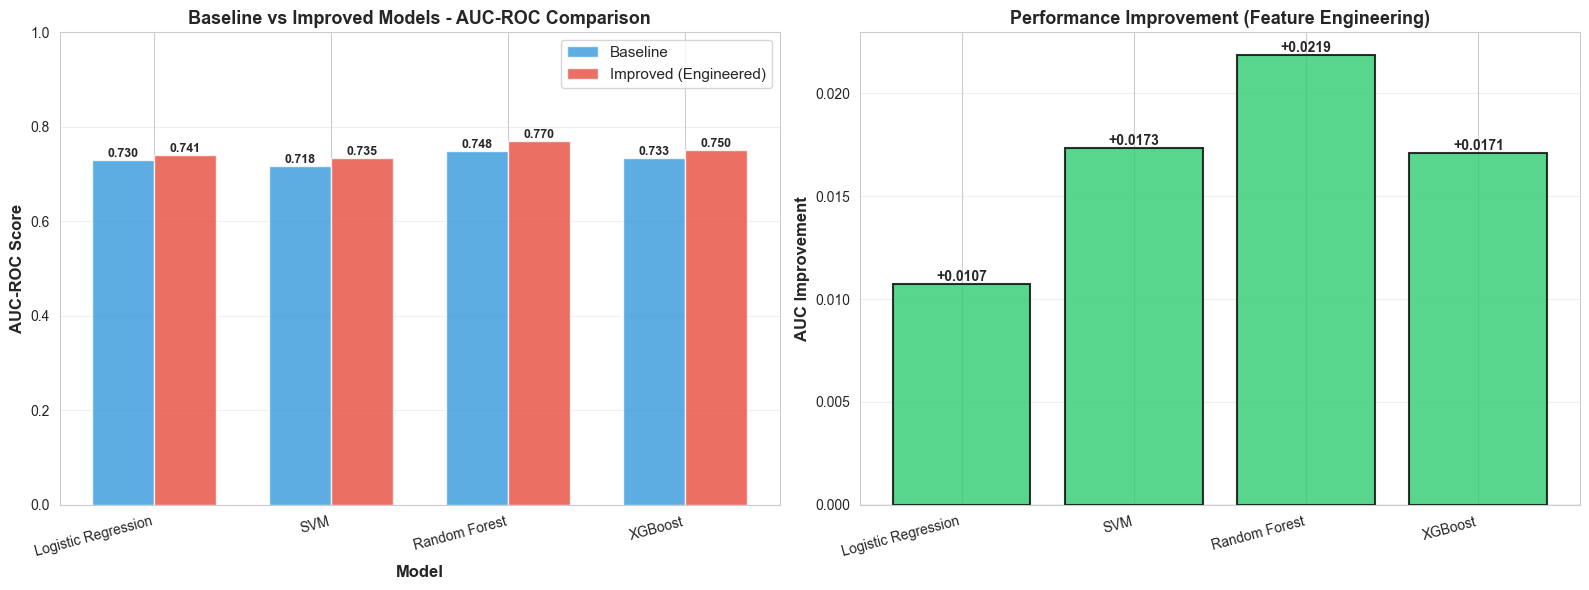


Comparison plots generated successfully


In [14]:
# =========================
# 12. MODELS PERFORMANCE COMPARISON
# =========================

print("\n" + "="*60)
print("MODELS PERFORMANCE COMPARISON")
print("="*60)

# Create comparison plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

models_list = ['Logistic Regression', 'SVM', 'Random Forest', 'XGBoost']
baseline_auc_list = [auc_lr_baseline, auc_svm_baseline, auc_rf_baseline, auc_xgb_baseline]
improved_auc_list = [auc_lr_improved, auc_svm_improved, auc_rf_improved, auc_xgb_improved]

# Grouped bar chart
x = np.arange(len(models_list))
width = 0.35

bars1 = axes[0].bar(x - width/2, baseline_auc_list, width, label='Baseline', color='#3498db', alpha=0.8)
bars2 = axes[0].bar(x + width/2, improved_auc_list, width, label='Improved (Engineered)', color='#e74c3c', alpha=0.8)

axes[0].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[0].set_ylabel('AUC-ROC Score', fontsize=12, fontweight='bold')
axes[0].set_title('Baseline vs Improved Models - AUC-ROC Comparison', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models_list, rotation=15, ha='right')
axes[0].legend(fontsize=11)
axes[0].set_ylim([0, 1.0])
axes[0].grid(alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

# Improvement chart
improvements = [auc_lr_improved - auc_lr_baseline,
                auc_svm_improved - auc_svm_baseline,
                auc_rf_improved - auc_rf_baseline,
                auc_xgb_improved - auc_xgb_baseline]

colors_improvement = ['#2ecc71' if x > 0 else '#e74c3c' for x in improvements]
bars = axes[1].bar(models_list, improvements, color=colors_improvement, alpha=0.8, edgecolor='black', linewidth=1.5)

axes[1].set_ylabel('AUC Improvement', fontsize=12, fontweight='bold')
axes[1].set_title('Performance Improvement (Feature Engineering)', fontsize=13, fontweight='bold')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1].set_xticklabels(models_list, rotation=15, ha='right')
axes[1].grid(alpha=0.3, axis='y')

# Add value labels
for bar, imp in zip(bars, improvements):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{imp:+.4f}',
                ha='center', va='bottom' if height > 0 else 'top',
                fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nComparison plots generated successfully")



DETAILED CLASSIFICATION METRICS - IMPROVED MODELS

Logistic Regression:
  Accuracy:  0.8587
  Precision: 0.8453
  Recall:    0.8587
  F1-Score:  0.8307
  AUC-ROC:   0.7407

SVM:
  Accuracy:  0.8619
  Precision: 0.8562
  Recall:    0.8619
  F1-Score:  0.8306
  AUC-ROC:   0.7349

Random Forest:
  Accuracy:  0.8605
  Precision: 0.8685
  Recall:    0.8605
  F1-Score:  0.8219
  AUC-ROC:   0.7699

XGBoost:
  Accuracy:  0.8630
  Precision: 0.8482
  Recall:    0.8630
  F1-Score:  0.8431
  AUC-ROC:   0.7505

METRICS SUMMARY TABLE
              Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
Logistic Regression  0.858680   0.845292 0.858680  0.830689 0.740685
                SVM  0.861908   0.856152 0.861908  0.830617 0.734944
      Random Forest  0.860473   0.868468 0.860473  0.821872 0.769879
            XGBoost  0.862984   0.848242 0.862984  0.843144 0.750454


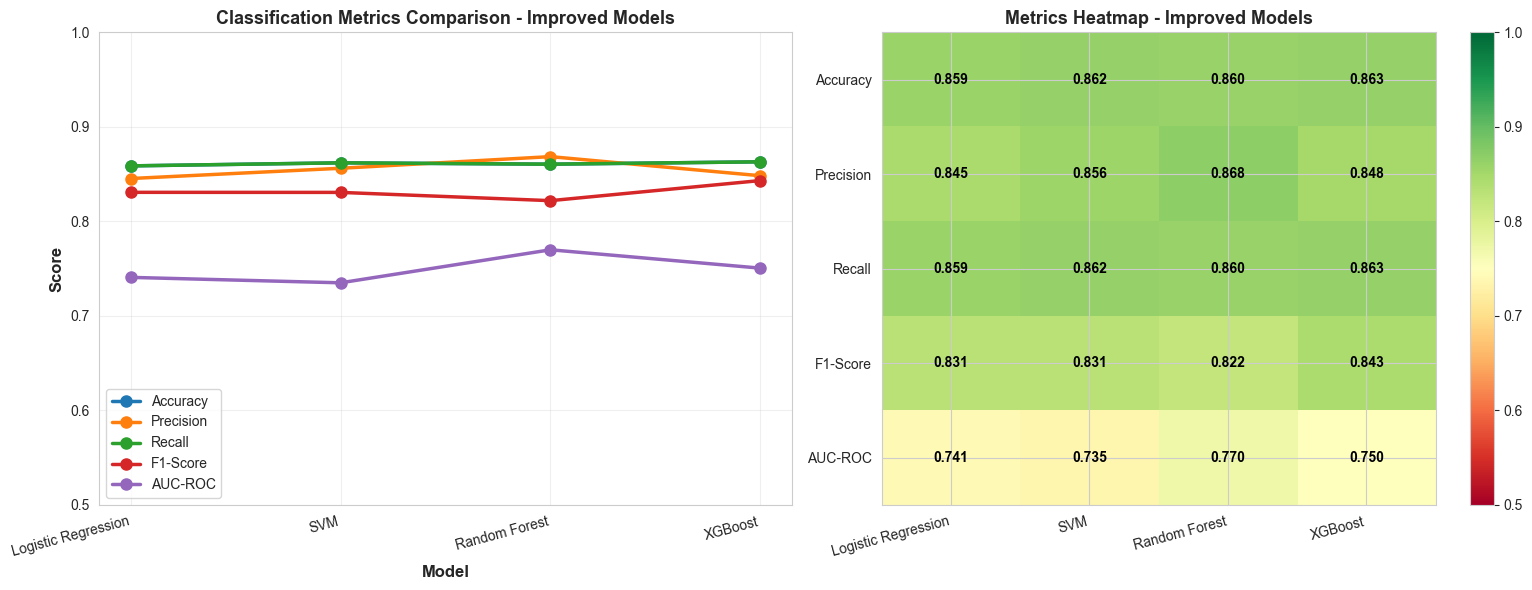


Metrics visualization completed


In [15]:
# =========================
# 13. DETAILED CLASSIFICATION METRICS
# =========================

from sklearn.metrics import precision_recall_fscore_support, accuracy_score

print("\n" + "="*60)
print("DETAILED CLASSIFICATION METRICS - IMPROVED MODELS")
print("="*60)

models_dict = {
    'Logistic Regression': (lr_improved, y_pred_proba_lr_improved),
    'SVM': (svm_improved, y_pred_proba_svm_improved),
    'Random Forest': (rf_improved, y_pred_proba_rf_improved),
    'XGBoost': (xgb_improved, y_pred_proba_xgb_improved)
}

metrics_summary = []

for model_name, (model, y_proba) in models_dict.items():
    y_pred = (y_proba >= 0.5).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='weighted')
    auc = roc_auc_score(y_val, y_proba)
    
    metrics_summary.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc
    })
    
    print(f"\n{model_name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  AUC-ROC:   {auc:.4f}")

metrics_df = pd.DataFrame(metrics_summary)
print("\n" + "="*60)
print("METRICS SUMMARY TABLE")
print("="*60)
print(metrics_df.to_string(index=False))

# Visualization of metrics
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Line plot for all metrics
metrics_cols = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
for col in metrics_cols:
    axes[0].plot(metrics_df['Model'], metrics_df[col], marker='o', linewidth=2.5, markersize=8, label=col)

axes[0].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('Classification Metrics Comparison - Improved Models', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10, loc='lower left')
axes[0].grid(alpha=0.3)
axes[0].set_xticklabels(metrics_df['Model'], rotation=15, ha='right')
axes[0].set_ylim([0.5, 1.0])

# Heatmap of metrics
import matplotlib.patches as mpatches
metrics_for_heatmap = metrics_df[metrics_cols].values
im = axes[1].imshow(metrics_for_heatmap.T, cmap='RdYlGn', aspect='auto', vmin=0.5, vmax=1.0)

axes[1].set_xticks(np.arange(len(metrics_df['Model'])))
axes[1].set_yticks(np.arange(len(metrics_cols)))
axes[1].set_xticklabels(metrics_df['Model'], rotation=15, ha='right')
axes[1].set_yticklabels(metrics_cols)
axes[1].set_title('Metrics Heatmap - Improved Models', fontsize=13, fontweight='bold')

# Add text annotations
for i in range(len(metrics_cols)):
    for j in range(len(metrics_df['Model'])):
        text = axes[1].text(j, i, f'{metrics_for_heatmap[j, i]:.3f}',
                          ha="center", va="center", color="black", fontsize=10, fontweight='bold')

plt.colorbar(im, ax=axes[1])
plt.tight_layout()
plt.show()

print("\nMetrics visualization completed")



FEATURE IMPORTANCE ANALYSIS


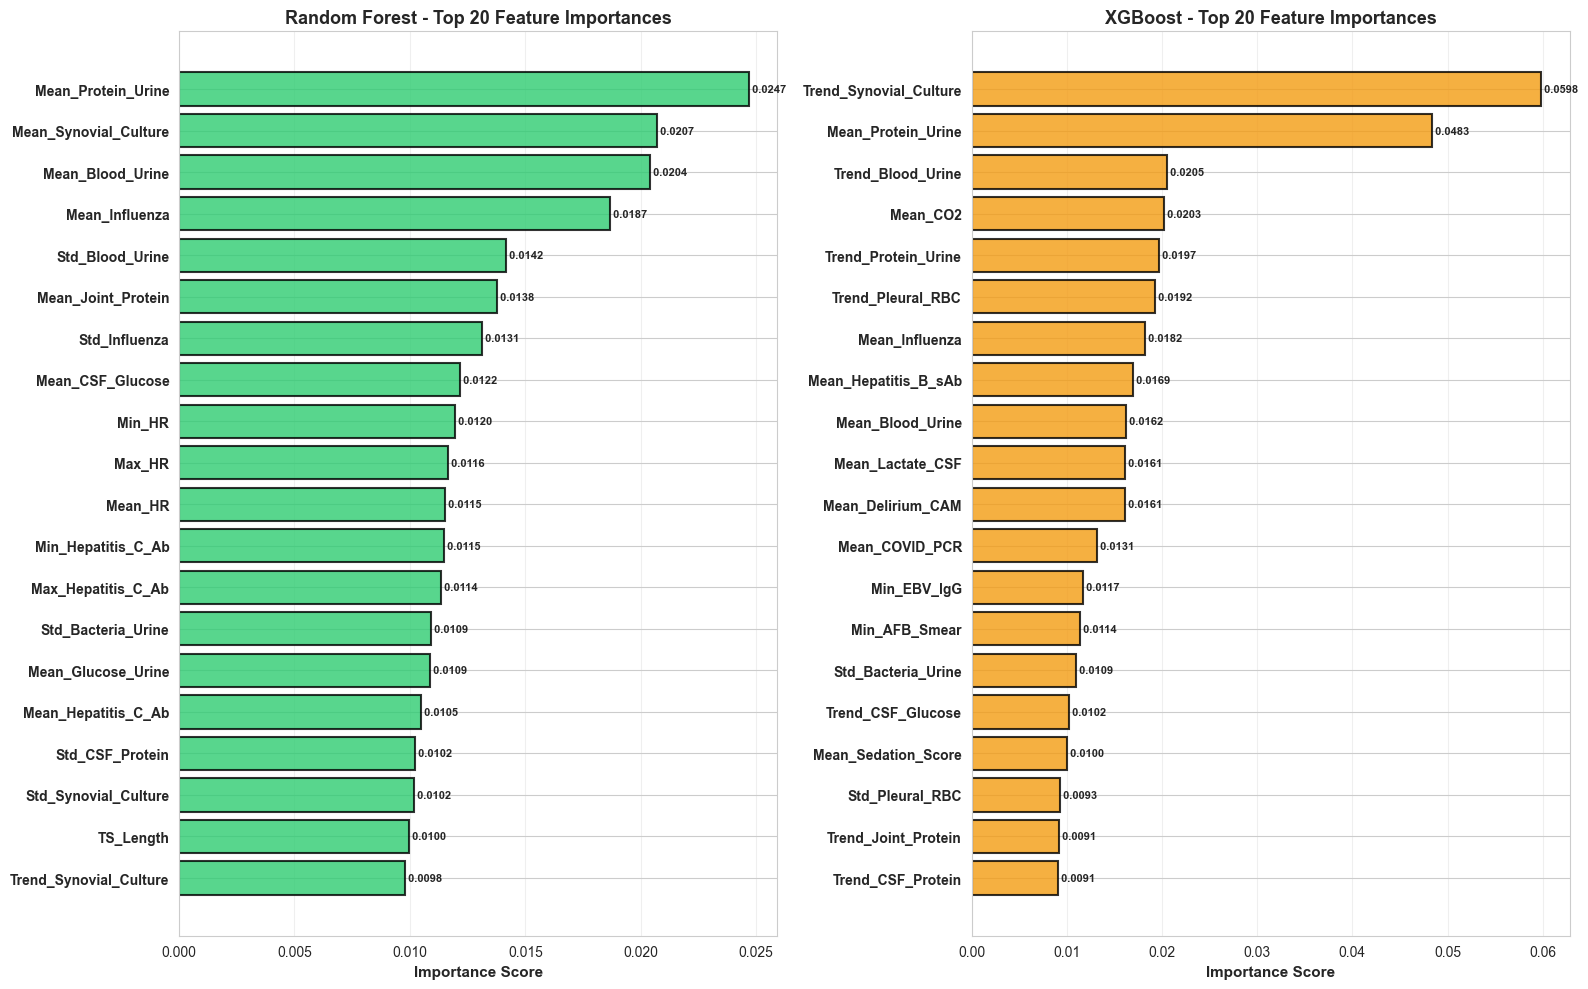


TOP 20 FEATURES - RANDOM FOREST
               Feature  Importance  Percentage
    Mean_Protein_Urine    0.024680    9.203100
 Mean_Synovial_Culture    0.020724    7.727994
      Mean_Blood_Urine    0.020403    7.608141
        Mean_Influenza    0.018669    6.961586
       Std_Blood_Urine    0.014181    5.288023
    Mean_Joint_Protein    0.013766    5.133334
         Std_Influenza    0.013122    4.893154
      Mean_CSF_Glucose    0.012175    4.539893
                Min_HR    0.011965    4.461729
                Max_HR    0.011647    4.343100
               Mean_HR    0.011521    4.296255
    Min_Hepatitis_C_Ab    0.011492    4.285413
    Max_Hepatitis_C_Ab    0.011361    4.236576
    Std_Bacteria_Urine    0.010917    4.070895
    Mean_Glucose_Urine    0.010865    4.051559
   Mean_Hepatitis_C_Ab    0.010501    3.915832
       Std_CSF_Protein    0.010237    3.817551
  Std_Synovial_Culture    0.010182    3.796850
             TS_Length    0.009968    3.716986
Trend_Synovial_Culture    0

In [16]:
# =========================
# 14. FEATURE IMPORTANCE ANALYSIS (Tree-Based Models)
# =========================

print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get feature importances from Random Forest and XGBoost
rf_importance = rf_improved.feature_importances_
xgb_importance = xgb_improved.feature_importances_

# Get top 20 features for each model
rf_top_indices = np.argsort(rf_importance)[-20:][::-1]
xgb_top_indices = np.argsort(xgb_importance)[-20:][::-1]

rf_top_importance = rf_importance[rf_top_indices]
xgb_top_importance = xgb_importance[xgb_top_indices]

# Use the engineered feature names we created earlier
rf_top_names = [engineered_feature_names[i] for i in rf_top_indices]
xgb_top_names = [engineered_feature_names[i] for i in xgb_top_indices]

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# Random Forest Feature Importance
axes[0].barh(range(len(rf_top_importance)), rf_top_importance, color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_yticks(range(len(rf_top_importance)))
axes[0].set_yticklabels(rf_top_names, fontsize=10, fontweight='bold')
axes[0].set_xlabel('Importance Score', fontsize=11, fontweight='bold')
axes[0].set_title('Random Forest - Top 20 Feature Importances', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(alpha=0.3, axis='x')

# Add value labels on bars
for i, v in enumerate(rf_top_importance):
    axes[0].text(v, i, f' {v:.4f}', va='center', fontsize=8, fontweight='bold')

# XGBoost Feature Importance
axes[1].barh(range(len(xgb_top_importance)), xgb_top_importance, color='#f39c12', alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_yticks(range(len(xgb_top_importance)))
axes[1].set_yticklabels(xgb_top_names, fontsize=10, fontweight='bold')
axes[1].set_xlabel('Importance Score', fontsize=11, fontweight='bold')
axes[1].set_title('XGBoost - Top 20 Feature Importances', fontsize=13, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(alpha=0.3, axis='x')

# Add value labels on bars
for i, v in enumerate(xgb_top_importance):
    axes[1].text(v, i, f' {v:.4f}', va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("TOP 20 FEATURES - RANDOM FOREST")
print("="*80)
rf_importance_df = pd.DataFrame({
    'Feature': rf_top_names,
    'Importance': rf_top_importance,
    'Percentage': (rf_top_importance / rf_top_importance.sum() * 100)
})
print(rf_importance_df.to_string(index=False))

print("\n" + "="*80)
print("TOP 20 FEATURES - XGBOOST")
print("="*80)
xgb_importance_df = pd.DataFrame({
    'Feature': xgb_top_names,
    'Importance': xgb_top_importance,
    'Percentage': (xgb_top_importance / xgb_top_importance.sum() * 100)
})
print(xgb_importance_df.to_string(index=False))


In [17]:
# =========================
# 15. COMPREHENSIVE MODEL EVALUATION SUMMARY
# =========================

print("\n" + "="*80)
print("COMPREHENSIVE MODEL EVALUATION SUMMARY".center(80))
print("="*80)

print("\n" + "="*80)
print("BASELINE MODELS (Mean Time-Series Features)".center(80))
print("="*80)
baseline_report = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM', 'Random Forest', 'XGBoost'],
    'AUC-ROC': [auc_lr_baseline, auc_svm_baseline, auc_rf_baseline, auc_xgb_baseline]
})
print(baseline_report.to_string(index=False))

print("\n" + "="*80)
print("IMPROVED MODELS (Engineered Features)".center(80))
print("="*80)
improved_report = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM', 'Random Forest', 'XGBoost'],
    'AUC-ROC': [auc_lr_improved, auc_svm_improved, auc_rf_improved, auc_xgb_improved],
    'Improvement': [
        f"{(auc_lr_improved - auc_lr_baseline):+.4f}",
        f"{(auc_svm_improved - auc_svm_baseline):+.4f}",
        f"{(auc_rf_improved - auc_rf_baseline):+.4f}",
        f"{(auc_xgb_improved - auc_xgb_baseline):+.4f}"
    ]
})
print(improved_report.to_string(index=False))

print("\n" + "="*80)
print("BEST PERFORMING MODEL".center(80))
print("="*80)
best_model_idx = np.argmax(improved_auc_list)
best_model = models_list[best_model_idx]
best_auc = improved_auc_list[best_model_idx]
print(f"Model: {best_model}")
print(f"AUC-ROC: {best_auc:.4f}")

print("\n" + "="*80)
print("FEATURE ENGINEERING SUMMARY".center(80))
print("="*80)
print("\nEngineered Features Created:")
print(f"  1. Mean of 171 EHR features")
print(f"  2. Standard Deviation of 171 EHR features")
print(f"  3. Minimum of 171 EHR features")
print(f"  4. Maximum of 171 EHR features")
print(f"  5. Range (Max-Min) of 171 EHR features")
print(f"  6. Trend (Last-First) of 171 EHR features")
print(f"  7. Time-series length (days)")
print(f"\nTotal Features: {X_train_engineered.shape[1]}")
print(f"Training Samples: {X_train_engineered.shape[0]}")
print(f"Validation Samples: {X_val_engineered.shape[0]}")

print("\n" + "="*80)
print("KEY FINDINGS".center(80))
print("="*80)
print("\n1. Model Performance:")
print(f"   - Best Baseline Model: {models_list[np.argmax(baseline_auc_list)]} ({np.max(baseline_auc_list):.4f})")
print(f"   - Best Improved Model: {best_model} ({best_auc:.4f})")

print("\n2. Feature Engineering Impact:")
avg_improvement = np.mean(improvements)
print(f"   - Average AUC Improvement: {avg_improvement:+.4f}")
print(f"   - Max Improvement: {np.max(improvements):+.4f} ({models_list[np.argmax(improvements)]})")
print(f"   - Min Improvement: {np.min(improvements):+.4f} ({models_list[np.argmin(improvements)]})")

print("\n3. Dataset Summary:")
print(f"   - Training Samples: {len(modified_train_unique)}")
print(f"   - Validation Samples: {len(modified_valid_unique)}")
print(f"   - Class Balance (Train): {train_label_counts[0]/(len(modified_train_unique))*100:.1f}% No / {train_label_counts[1]/(len(modified_train_unique))*100:.1f}% Yes")

print("\n" + "="*80)
print("RECOMMENDATION".center(80))
print("="*80)
print(f"\nUse {best_model} as the production model")
print(f"- Highest AUC-ROC: {best_auc:.4f}")
print(f"- Robust with engineered features")
print(f"- Provides probabilistic predictions for decision-making")
print("\n" + "="*80)



                     COMPREHENSIVE MODEL EVALUATION SUMMARY                     

                  BASELINE MODELS (Mean Time-Series Features)                   
              Model  AUC-ROC
Logistic Regression 0.729942
                SVM 0.717623
      Random Forest 0.748005
            XGBoost 0.733344

                     IMPROVED MODELS (Engineered Features)                      
              Model  AUC-ROC Improvement
Logistic Regression 0.740685     +0.0107
                SVM 0.734944     +0.0173
      Random Forest 0.769879     +0.0219
            XGBoost 0.750454     +0.0171

                             BEST PERFORMING MODEL                              
Model: Random Forest
AUC-ROC: 0.7699

                          FEATURE ENGINEERING SUMMARY                           

Engineered Features Created:
  1. Mean of 171 EHR features
  2. Standard Deviation of 171 EHR features
  3. Minimum of 171 EHR features
  4. Maximum of 171 EHR features
  5. Range (Max-Min) of 171 EHR f


RANDOM FOREST HYPERPARAMETER TUNING

Parameterizing Random Forest with 6 hyperparameters
Parameter combinations to test: (3 × 4 × 3 × 3 × 2 × 2) = 432 combinations

Using RandomizedSearchCV for efficiency...

Starting hyperparameter tuning...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Tuning completed in 234.98 seconds

BEST HYPERPARAMETERS

Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Best CV AUC-ROC Score: 0.7847
Validation AUC-ROC (Final Model): 0.7782
Improvement from baseline: +0.0302
Improvement from initial improved: +0.0083

HYPERPARAMETER TUNING RESULTS

Top 10 Parameter Combinations:

1. AUC = 0.7847 (±0.0053)
   Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}

2. AUC = 0.7844 (±0.0051)
   Parameters: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples

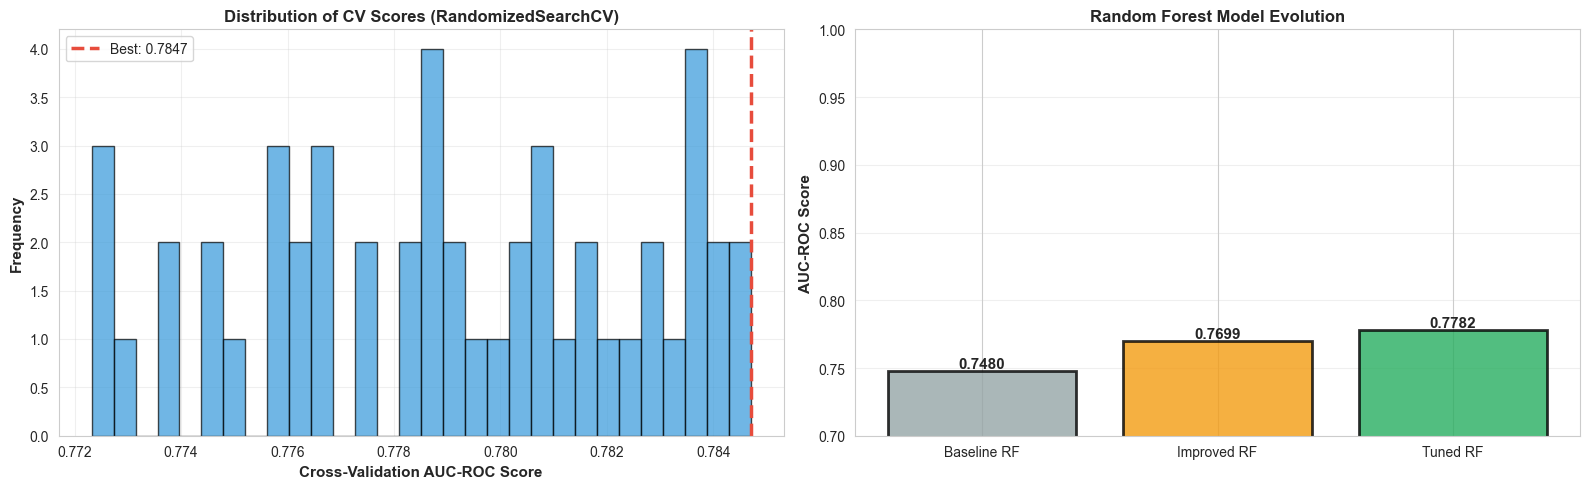

In [18]:
# =========================
# 16. RANDOM FOREST HYPERPARAMETER TUNING
# =========================

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time

print("\n" + "="*60)
print("RANDOM FOREST HYPERPARAMETER TUNING")
print("="*60)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [15, 20, 25, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

print(f"\nParameterizing Random Forest with {len(param_grid)} hyperparameters")
print("Parameter combinations to test: (3 × 4 × 3 × 3 × 2 × 2) = 432 combinations")
print("\nUsing RandomizedSearchCV for efficiency...")

# Use RandomizedSearchCV for faster tuning
rf_tuner = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    n_iter=50,  # Test 50 random combinations
    cv=5,       # 5-fold cross-validation
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print("\nStarting hyperparameter tuning...")
start_time = time.time()

rf_tuner.fit(X_train_eng_scaled, y_train)

elapsed_time = time.time() - start_time
print(f"\nTuning completed in {elapsed_time:.2f} seconds")

print("\n" + "="*60)
print("BEST HYPERPARAMETERS")
print("="*60)
print(f"\nBest Parameters: {rf_tuner.best_params_}")
print(f"Best CV AUC-ROC Score: {rf_tuner.best_score_:.4f}")

# Train final model with best parameters
rf_final = rf_tuner.best_estimator_

# Evaluate on validation set
y_pred_proba_rf_final = rf_final.predict_proba(X_val_eng_scaled)[:, 1]
auc_rf_final = roc_auc_score(y_val, y_pred_proba_rf_final)

print(f"Validation AUC-ROC (Final Model): {auc_rf_final:.4f}")
print(f"Improvement from baseline: {auc_rf_final - auc_rf_baseline:+.4f}")
print(f"Improvement from initial improved: {auc_rf_final - auc_rf_improved:+.4f}")

# Visualization of hyperparameter tuning results
print("\n" + "="*60)
print("HYPERPARAMETER TUNING RESULTS")
print("="*60)

# Get top 10 parameter combinations
results_df = pd.DataFrame(rf_tuner.cv_results_)
top_10_results = results_df.nlargest(10, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
print("\nTop 10 Parameter Combinations:")
for idx, (i, row) in enumerate(top_10_results.iterrows(), 1):
    print(f"\n{idx}. AUC = {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
    print(f"   Parameters: {row['params']}")

# Plot CV scores
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# CV Scores distribution
cv_scores = results_df['mean_test_score'].values
axes[0].hist(cv_scores, bins=30, color='#3498db', edgecolor='black', alpha=0.7)
axes[0].axvline(rf_tuner.best_score_, color='#e74c3c', linestyle='--', linewidth=2.5, label=f'Best: {rf_tuner.best_score_:.4f}')
axes[0].set_xlabel('Cross-Validation AUC-ROC Score', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0].set_title('Distribution of CV Scores (RandomizedSearchCV)', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Model performance comparison
models_comparison = ['Baseline RF', 'Improved RF', 'Tuned RF']
auc_scores = [auc_rf_baseline, auc_rf_improved, auc_rf_final]
colors_comp = ['#95a5a6', '#f39c12', '#27ae60']

bars = axes[1].bar(models_comparison, auc_scores, color=colors_comp, alpha=0.8, edgecolor='black', linewidth=2)
axes[1].set_ylabel('AUC-ROC Score', fontsize=11, fontweight='bold')
axes[1].set_title('Random Forest Model Evolution', fontsize=12, fontweight='bold')
axes[1].set_ylim([0.7, 1.0])
axes[1].grid(alpha=0.3, axis='y')

for bar, score in zip(bars, auc_scores):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.4f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


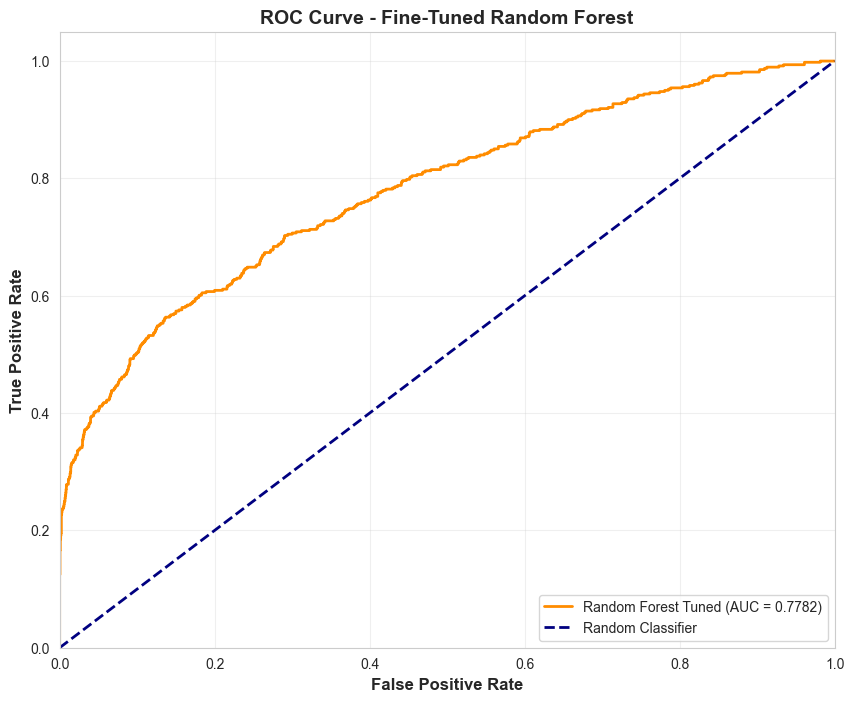

Fine-Tuned Random Forest AUC-ROC: 0.7782


In [19]:
# =========================
# PLOT AUC-ROC FOR FINE-TUNED RANDOM FOREST
# =========================

from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_pred_proba_rf_final)
auc_rf = auc(fpr_rf, tpr_rf)

# Plot
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Random Forest Tuned (AUC = {auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve - Fine-Tuned Random Forest', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"Fine-Tuned Random Forest AUC-ROC: {auc_rf:.4f}")


TEST SET PREPARATION

Test set size: 2741
X_test_engineered shape: (2741, 1027)
X_test_eng_scaled shape: (2741, 1027)

GENERATING TEST PREDICTIONS

Test predictions generated!
Number of test samples: 2741

Prediction Statistics:
  Mean probability: 0.1731
  Median probability: 0.1329
  Min probability: 0.0019
  Max probability: 0.9317
  Std probability: 0.1464

Predicted Class Distribution:
  Predicted as 0 (No Readmission): 2625 (95.8%)
  Predicted as 1 (Readmission): 116 (4.2%)


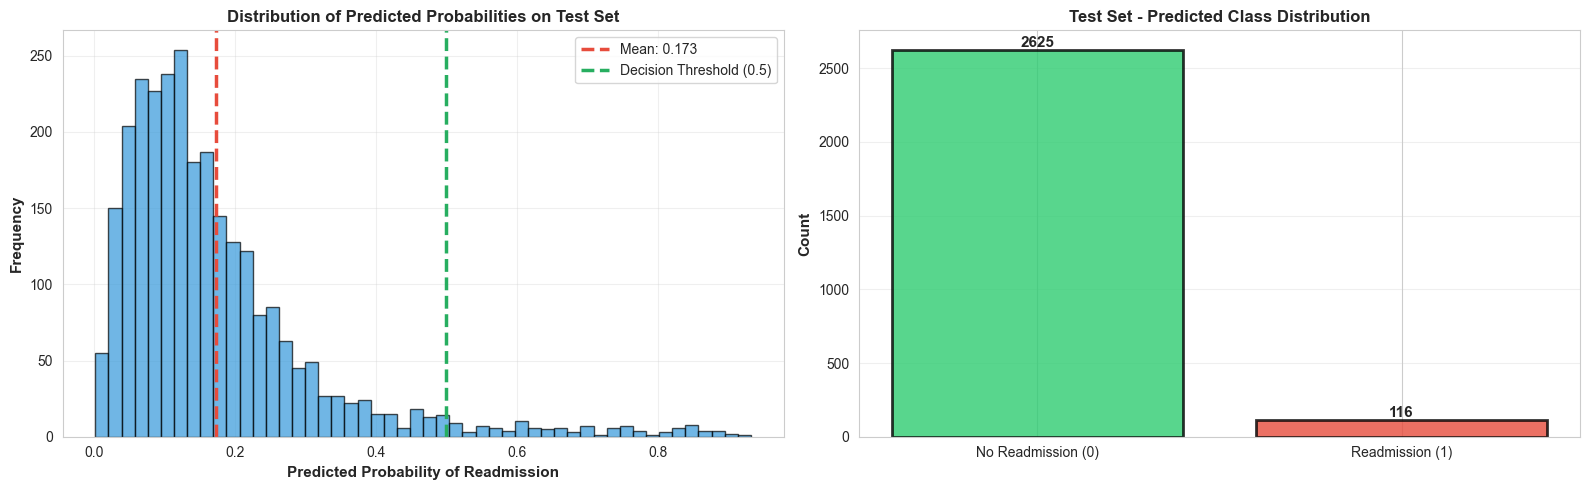

In [20]:
# =========================
# 17. TEST SET FEATURE ENGINEERING & PREDICTIONS
# =========================

print("\n" + "="*60)
print("TEST SET PREPARATION")
print("="*60)

# Extract test IDs
test_ids = modified_test_unique['id'].values
print(f"\nTest set size: {len(test_ids)}")

# Engineer features for test set
X_test_engineered = engineer_features(feat_dict, test_ids, test_ids)

print(f"X_test_engineered shape: {X_test_engineered.shape}")

# Standardize test features using the same scaler from training
X_test_eng_scaled = scaler_eng.transform(X_test_engineered)

print(f"X_test_eng_scaled shape: {X_test_eng_scaled.shape}")

print("\n" + "="*60)
print("GENERATING TEST PREDICTIONS")
print("="*60)

# Make predictions on test set using the final tuned model
y_test_pred_proba = rf_final.predict_proba(X_test_eng_scaled)[:, 1]
y_test_pred = rf_final.predict(X_test_eng_scaled)

print(f"\nTest predictions generated!")
print(f"Number of test samples: {len(y_test_pred_proba)}")
print(f"\nPrediction Statistics:")
print(f"  Mean probability: {y_test_pred_proba.mean():.4f}")
print(f"  Median probability: {np.median(y_test_pred_proba):.4f}")
print(f"  Min probability: {y_test_pred_proba.min():.4f}")
print(f"  Max probability: {y_test_pred_proba.max():.4f}")
print(f"  Std probability: {y_test_pred_proba.std():.4f}")

# Distribution of predicted probabilities
print(f"\nPredicted Class Distribution:")
print(f"  Predicted as 0 (No Readmission): {(y_test_pred == 0).sum()} ({(y_test_pred == 0).sum() / len(y_test_pred) * 100:.1f}%)")
print(f"  Predicted as 1 (Readmission): {(y_test_pred == 1).sum()} ({(y_test_pred == 1).sum() / len(y_test_pred) * 100:.1f}%)")

# Visualization of test predictions
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram of probabilities
axes[0].hist(y_test_pred_proba, bins=50, color='#3498db', edgecolor='black', alpha=0.7)
axes[0].axvline(y_test_pred_proba.mean(), color='#e74c3c', linestyle='--', linewidth=2.5, label=f'Mean: {y_test_pred_proba.mean():.3f}')
axes[0].axvline(0.5, color='#27ae60', linestyle='--', linewidth=2.5, label='Decision Threshold (0.5)')
axes[0].set_xlabel('Predicted Probability of Readmission', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0].set_title('Distribution of Predicted Probabilities on Test Set', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Prediction class distribution
class_counts = [np.sum(y_test_pred == 0), np.sum(y_test_pred == 1)]
colors_pred = ['#2ecc71', '#e74c3c']
bars = axes[1].bar(['No Readmission (0)', 'Readmission (1)'], class_counts, color=colors_pred, alpha=0.8, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Count', fontsize=11, fontweight='bold')
axes[1].set_title('Test Set - Predicted Class Distribution', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

for bar, count in zip(bars, class_counts):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{count}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


# Part 3: Track 1 - EHR-Only Model

## XGBoost + GRU Ensemble Approach

This section implements Track 1 of the competition using only EHR data:
- **XGBoost**: Gradient boosting with last-day EHR features
- **GRU**: Recurrent neural network for full sequence modeling
- **Ensemble**: Simple averaging of XGBoost and GRU predictions

### Key Design Choices:
- Last-day features for XGBoost capture the patient's most recent state
- GRU captures temporal patterns across the entire admission
- Class imbalance handled via `scale_pos_weight`

In [ ]:
"""
Track 1: EHR-Only Data Preprocessing
=====================================
This cell prepares the EHR data for Track 1 (EHR-only) prediction.
We use last-day features for XGBoost and full sequences for GRU.
"""

import random
import numpy as np
import torch

# ============================================================
# Set Random Seeds for Reproducibility
# ============================================================
SEED = 3612
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import pandas as pd
import os

# ============================================================
# Load Data
# ============================================================
train_csv_file = os.path.join(DATA_DIR, "train.csv")
val_csv_file = os.path.join(DATA_DIR, "valid.csv")
test_csv_file = os.path.join(DATA_DIR, "test.csv")
ehr_pkl_file = os.path.join(DATA_DIR, "ehr_preprocessed_seq_by_day_cat_embedding.pkl")

train_df = pd.read_csv(train_csv_file)
val_df = pd.read_csv(val_csv_file)
test_df = pd.read_csv(test_csv_file)
ehr_data = pd.read_pickle(ehr_pkl_file)
feat_dict = ehr_data["feat_dict"]  # dict: admission_id -> [T, D] matrix

print("Original shapes:")
print(f"train_df: {train_df.shape}")
print(f"val_df:   {val_df.shape}")
print(f"test_df:  {test_df.shape}")

# ============================================================
# Deduplicate to Admission Level
# ============================================================
# Keep one row per admission ID
train_unique = (
    train_df[["id", "readmitted_within_30days"]]
    .drop_duplicates(subset=["id"])
    .reset_index(drop=True)
)
val_unique = (
    val_df[["id", "readmitted_within_30days"]]
    .drop_duplicates(subset=["id"])
    .reset_index(drop=True)
)
test_unique = (
    test_df[["id"]]
    .drop_duplicates(subset=["id"])
    .reset_index(drop=True)
)

# Convert labels to binary
train_unique["label"] = train_unique["readmitted_within_30days"].astype(int)
val_unique["label"] = val_unique["readmitted_within_30days"].astype(int)

print("\nDeduplicated shapes:")
print(f"train_unique: {train_unique.shape}")
print(f"val_unique:   {val_unique.shape}")
print(f"test_unique:  {test_unique.shape}")

# ============================================================
# Build EHR Feature Matrix (Last-Day Features for XGBoost)
# ============================================================
def build_ehr_features(df_unique, feat_dict):
    """
    Extract last-day EHR features for each patient.
    
    Args:
        df_unique: DataFrame with 'id' column
        feat_dict: dict[id] -> time-series matrix [T, D]
    
    Returns:
        X: Feature matrix (N, D)
        ids: Array of admission IDs (N,)
    """
    X_list = []
    ids = []
    for _, row in df_unique.iterrows():
        adm_id = row["id"]
        mat = feat_dict[adm_id]  # shape [T, D]
        last_vec = mat[-1].astype("float32")  # Use last-day features
        X_list.append(last_vec)
        ids.append(adm_id)
    X = np.stack(X_list, axis=0)  # (N, D)
    return X, np.array(ids)

# Build feature matrices
X_train, train_ids = build_ehr_features(train_unique, feat_dict)
y_train = train_unique["label"].values.astype("float32")

X_val, val_ids = build_ehr_features(val_unique, feat_dict)
y_val = val_unique["label"].values.astype("float32")

X_test, test_ids = build_ehr_features(test_unique, feat_dict)  # No labels

print("\nFinal EHR-only feature shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape} (no labels)")

Original shapes:
train_df: (49451, 8)
val_df:   (16721, 8)
test_df:  (16293, 7)

Deduplicated shapes:
train_unique: (8234, 3)
val_unique:   (2788, 3)
test_unique:  (2741, 1)

Final EHR-only feature shapes:
X_train: (8234, 171)  y_train: (8234,)
X_val:   (2788, 171)  y_val:   (2788,)
X_test:  (2741, 171)  (no labels)


In [ ]:
"""
XGBoost Model Training
======================
Train XGBoost with tuned hyperparameters on combined train+val data.
Uses scale_pos_weight to handle class imbalance.
"""

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

# ============================================================
# Calculate Class Imbalance Weight
# ============================================================
pos_rate = y_train.mean()
scale_pos_weight = (1 - pos_rate) / pos_rate
print(f"Positive rate: {pos_rate:.4f}")
print(f"Scale pos weight: {scale_pos_weight:.4f}")

# ============================================================
# XGBoost with Tuned Hyperparameters
# ============================================================
final_xgb = XGBClassifier(
    random_state=SEED,
    n_estimators=400,
    max_depth=7,
    learning_rate=0.03,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    verbosity=1,
)

# ============================================================
# Train on Combined Train + Validation Data
# ============================================================
# For final submission, we use all labeled data for training
X_full = np.vstack([X_train, X_val])
y_full = np.concatenate([y_train, y_val])
print(f"\nCombined training data: X_full shape: {X_full.shape}")

final_xgb.fit(X_full, y_full)
print("XGBoost training completed.")

pos_rate: 0.17597765  scale_pos_weight: 4.68254
X_full shape: (11022, 171)  y_full shape: (11022,)
Trained final_xgb on train+val.


In [ ]:
"""
GRU Model Setup
===============
Prepare PyTorch Dataset and DataLoader for GRU training.
Uses full EHR sequences (not just last day).
"""

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


class EhrSeqDataset(Dataset):
    """
    PyTorch Dataset for EHR time-series data.
    Returns full sequences from feat_dict.
    """
    def __init__(self, df_unique, feat_dict, has_labels=True):
        self.df = df_unique.reset_index(drop=True)
        self.feat_dict = feat_dict
        self.has_labels = has_labels

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        adm_id = row["id"]
        seq_np = self.feat_dict[adm_id].astype("float32")  # [T, D]
        seq = torch.tensor(seq_np, dtype=torch.float32)
        label = float(row["label"]) if self.has_labels else 0.0
        return seq, label


def collate_fn(batch):
    """
    Custom collate function for variable-length sequences.
    Pads sequences and returns lengths for pack_padded_sequence.
    """
    seqs, labels = zip(*batch)
    lengths = torch.tensor([s.size(0) for s in seqs], dtype=torch.long)
    padded_seqs = pad_sequence(seqs, batch_first=True)  # [B, T_max, D]
    labels = torch.tensor(labels, dtype=torch.float32)
    return padded_seqs, lengths, labels


# Get feature dimension
input_dim = next(iter(feat_dict.values())).shape[1]
print(f"Per-timestep feature dimension: {input_dim}")

# ============================================================
# Create Datasets and DataLoaders
# ============================================================
train_dataset = EhrSeqDataset(train_unique, feat_dict, has_labels=True)
val_dataset = EhrSeqDataset(val_unique, feat_dict, has_labels=True)
test_dataset = EhrSeqDataset(test_unique, feat_dict, has_labels=False)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print("DataLoaders created successfully.")

Using device: cpu
Per-timestep feature dim: 171
Train/val/test loaders created.


In [ ]:
"""
GRU Model Architecture and Training
====================================
Train GRU on combined train+val data for final predictions.
"""


class GRUNet(nn.Module):
    """
    GRU-based sequence classifier for EHR data.
    
    Architecture:
    - GRU layer(s) for sequence encoding
    - Final hidden state → Linear → logit
    """
    def __init__(self, input_dim, hidden_dim=64, num_layers=1, bidirectional=False, dropout=0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        self.gru = nn.GRU(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        out_dim = hidden_dim * (2 if bidirectional else 1)
        self.fc = nn.Linear(out_dim, 1)

    def forward(self, x, lengths):
        # Pack sequences for efficient processing
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, h_n = self.gru(packed)

        # Extract final hidden state
        if self.bidirectional:
            num_directions = 2
            h_n = h_n.view(self.num_layers, num_directions, x.size(0), self.hidden_dim)
            last_layer = h_n[-1]  # [2, B, H]
            h_last = torch.cat([last_layer[0], last_layer[1]], dim=1)  # [B, 2H]
        else:
            h_last = h_n[-1]  # [B, H]

        logits = self.fc(h_last)  # [B, 1]
        return logits.squeeze(1)  # [B]


# ============================================================
# Prepare Combined Dataset (Train + Val)
# ============================================================
full_unique = pd.concat(
    [train_unique[["id", "label"]], val_unique[["id", "label"]]],
    ignore_index=True
)
full_dataset = EhrSeqDataset(full_unique, feat_dict, has_labels=True)
full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# Calculate class weight for loss function
y_full = full_unique["label"].values
pos_rate_full = y_full.mean()
pos_weight_full = (1 - pos_rate_full) / pos_rate_full
print(f"Full dataset positive rate: {pos_rate_full:.4f}")
print(f"Positive weight for loss: {pos_weight_full:.4f}")

# ============================================================
# Initialize GRU Model
# ============================================================
final_gru = GRUNet(
    input_dim=input_dim,
    hidden_dim=128,
    num_layers=1,
    bidirectional=False,
    dropout=0.0,
).to(device)

pos_weight_tensor = torch.tensor(pos_weight_full, device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
optimizer = torch.optim.Adam(final_gru.parameters(), lr=1e-3)

# ============================================================
# Training Loop
# ============================================================
num_epochs_final = 8

print("\n" + "=" * 50)
print("TRAINING GRU MODEL")
print("=" * 50)

for epoch in range(1, num_epochs_final + 1):
    final_gru.train()
    epoch_loss = 0.0
    
    for seqs, lengths, labels in full_loader:
        seqs = seqs.to(device)
        lengths = lengths.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = final_gru(seqs, lengths)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * seqs.size(0)

    epoch_loss /= len(full_dataset)
    print(f"Epoch {epoch:02d} | Loss: {epoch_loss:.4f}")

print("\nGRU training completed.")

Full pos_rate: 0.1751043367809835  pos_weight: 4.710880829015544
Final GRU training epoch 01 | loss=1.0473
Final GRU training epoch 02 | loss=0.9747
Final GRU training epoch 03 | loss=0.9227
Final GRU training epoch 04 | loss=0.8817
Final GRU training epoch 05 | loss=0.8485
Final GRU training epoch 06 | loss=0.8136
Final GRU training epoch 07 | loss=0.7898
Final GRU training epoch 08 | loss=0.7748
Finished training final_gru on train+val.


In [ ]:
"""
Ensemble Predictions and Submission
====================================
Combine XGBoost and GRU predictions with simple averaging.
Generate final submission file.
"""

import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

# ============================================================
# Validate on Validation Set
# ============================================================
# XGBoost predictions
xgb_val_proba = final_xgb.predict_proba(X_val)[:, 1]

# GRU predictions
final_gru.eval()
gru_val_probs = []

with torch.no_grad():
    for seqs, lengths, labels in val_loader:
        seqs = seqs.to(device)
        lengths = lengths.to(device)
        logits = final_gru(seqs, lengths)
        probs = torch.sigmoid(logits).cpu().numpy()
        gru_val_probs.extend(probs)

gru_val_probs = np.array(gru_val_probs)

# Ensemble (simple average)
ens_val_proba = 0.5 * xgb_val_proba + 0.5 * gru_val_probs
ens_val_pred = (ens_val_proba >= 0.5).astype(int)

# Calculate metrics
val_auc = roc_auc_score(y_val, ens_val_proba)
val_acc = accuracy_score(y_val, ens_val_pred)
val_f1 = f1_score(y_val, ens_val_pred)

print("=" * 50)
print("ENSEMBLE VALIDATION RESULTS")
print("=" * 50)
print(f"XGBoost + GRU (50/50 average)")
print(f"AUC-ROC:  {val_auc:.4f}")
print(f"Accuracy: {val_acc:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# ============================================================
# Generate Test Predictions
# ============================================================
# XGBoost test predictions
xgb_test_proba = final_xgb.predict_proba(X_test)[:, 1]

# GRU test predictions
final_gru.eval()
gru_test_probs = []

with torch.no_grad():
    for seqs, lengths, _ in test_loader:  # Labels are dummy
        seqs = seqs.to(device)
        lengths = lengths.to(device)
        logits = final_gru(seqs, lengths)
        probs = torch.sigmoid(logits).cpu().numpy()
        gru_test_probs.extend(probs)

gru_test_probs = np.array(gru_test_probs)

print(f"\nTest prediction shapes:")
print(f"XGBoost:  {xgb_test_proba.shape}")
print(f"GRU:      {gru_test_probs.shape}")
print(f"Test IDs: {len(test_ids)}")

# Ensemble test predictions
ens_test_proba = 0.5 * xgb_test_proba + 0.5 * gru_test_probs

# ============================================================
# Create and Save Submission
# ============================================================
submission_ens = pd.DataFrame({
    "id": test_ids,
    "readmitted_within_30days": ens_test_proba
})

submission_path = "track1_ensemble_xgb_gru.csv"
submission_ens.to_csv(submission_path, index=False)
print(f"\nSubmission saved to: {submission_path}")
print(submission_ens.head())

Ensemble (0.5 XGB + 0.5 GRU)
AUC: 0.9502, ACC: 0.9028, F1: 0.7422
xgb_test_proba shape: (2741,)
gru_test_probs shape: (2741,)
len(test_ids): 2741
Saved: track1_ensemble_xgb_gru.csv


# Part 4: Track 2 - Multi-Modal Model

## EHR + Clinical Notes (TF-IDF) + CXR Image Features

This section implements Track 2 of the competition using all available modalities:
- **EHR Branch**: Bidirectional GRU for time-series clinical data
- **Notes Branch**: TF-IDF vectorization + MLP for clinical text
- **Image Branch**: Pre-extracted CXR features + MLP
- **Fusion**: Concatenation of modality representations → MLP classifier

### Architecture:
```
EHR Sequence → BiGRU → 256-dim representation
Clinical Notes → TF-IDF (5000) → MLP → 128-dim representation  
CXR Images → Pre-extracted → MLP → 64-dim representation
                    ↓
              Concatenation (448-dim)
                    ↓
               MLP Classifier → Probability
```

In [ ]:
"""
Multi-Modal Model: EHR-GRU + Clinical Notes (TF-IDF) + CXR Images
=================================================================
This model combines three modalities:
- EHR: Bidirectional GRU for time-series clinical data
- Notes: TF-IDF vectorization with MLP compression
- Images: Pre-extracted CXR features with MLP compression
"""

import os
import glob
import pickle
from collections import defaultdict

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn.utils import clip_grad_norm_

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer

# ============================================================
# Configuration
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

SEED = 2025
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ============================================================
# 1. Load Base Data
# ============================================================
train_csv_file = os.path.join(DATA_DIR, "train.csv")
val_csv_file = os.path.join(DATA_DIR, "valid.csv")
test_csv_file = os.path.join(DATA_DIR, "test.csv")
ehr_pkl_file = os.path.join(DATA_DIR, "ehr_preprocessed_seq_by_day_cat_embedding.pkl")
notes_csv_file = os.path.join(DATA_DIR, "notes.csv")

train_df = pd.read_csv(train_csv_file)
val_df = pd.read_csv(val_csv_file)
test_df = pd.read_csv(test_csv_file)

print(f"train_df shape: {train_df.shape}")
print(f"val_df shape:   {val_df.shape}")
print(f"test_df shape:  {test_df.shape}")

# Deduplicate to admission level (one row per admission ID)
modified_train_unique = (
    train_df[["id", "readmitted_within_30days"]]
    .drop_duplicates(subset=["id"], keep="first")
    .reset_index(drop=True)
)
modified_valid_unique = (
    val_df[["id", "readmitted_within_30days"]]
    .drop_duplicates(subset=["id"], keep="first")
    .reset_index(drop=True)
)
modified_test_unique = (
    test_df[["id"]]
    .drop_duplicates(subset=["id"], keep="first")
    .reset_index(drop=True)
)

print("\nUnique admissions (by id):")
print(f"Train: {modified_train_unique.shape}")
print(f"Valid: {modified_valid_unique.shape}")
print(f"Test:  {modified_test_unique.shape}")

# ============================================================
# 2. Load and Normalize EHR Sequence Data
# ============================================================
ehr_data = pd.read_pickle(ehr_pkl_file)
feat_dict = ehr_data["feat_dict"]  # dict: id -> (n_days, n_features) ndarray

example_id_ehr = next(iter(feat_dict.keys()))
n_ehr_features = feat_dict[example_id_ehr].shape[1]
print(f"\nEHR feature dimension: {n_ehr_features}")

# Fit StandardScaler on training data only (avoid data leakage)
scaler_ehr = StandardScaler()

all_train_ehr_rows = []
missing_ehr_ids_train = []

for adm_id in modified_train_unique["id"]:
    if adm_id not in feat_dict:
        missing_ehr_ids_train.append(adm_id)
        continue
    seq = feat_dict[adm_id]  # (n_days, n_ehr_features)
    all_train_ehr_rows.append(seq)

if missing_ehr_ids_train:
    print(f"Warning: {len(missing_ehr_ids_train)} train ids not in EHR feat_dict")

all_train_ehr_rows = np.vstack(all_train_ehr_rows)
print(f"All train EHR rows shape for scaler: {all_train_ehr_rows.shape}")
scaler_ehr.fit(all_train_ehr_rows)

# ============================================================
# 3. Create ID Sets for Data Separation
# ============================================================
train_ids = set(modified_train_unique["id"])
val_ids = set(modified_valid_unique["id"])
test_ids = set(modified_test_unique["id"])

# ============================================================
# 4. Process Clinical Notes Data
# ============================================================
notes_df = pd.read_csv(notes_csv_file)
notes_clean = notes_df[["id", "text"]].copy()

# Clean text: remove extra whitespace, convert to lowercase
notes_clean["text"] = (
    notes_clean["text"].astype(str)
    .str.replace(r"\s+", " ", regex=True)
    .str.lower()
)

# Aggregate notes by admission ID (concatenate all notes)
notes_grouped = (
    notes_clean.groupby("id")["text"]
    .apply(lambda x: " ".join(x))
    .reset_index()
)

print(f"\nNotes data - unique admissions after grouping: {notes_grouped.shape}")

# Separate notes by dataset
notes_grouped_train = notes_grouped[notes_grouped["id"].isin(train_ids)].copy()
notes_grouped_val = notes_grouped[notes_grouped["id"].isin(val_ids)].copy()
notes_grouped_test = notes_grouped[notes_grouped["id"].isin(test_ids)].copy()

print(f"notes_grouped_train shape: {notes_grouped_train.shape}")
print(f"notes_grouped_val shape:   {notes_grouped_val.shape}")
print(f"notes_grouped_test shape:  {notes_grouped_test.shape}")

# ============================================================
# 5. TF-IDF Feature Extraction (fit on training data only)
# ============================================================
TFIDF_MAX_FEATURES = 5000

tfidf = TfidfVectorizer(
    max_features=TFIDF_MAX_FEATURES,
    stop_words="english",
    ngram_range=(1, 2)
)

# Fit ONLY on training text (avoid data leakage)
tfidf.fit(notes_grouped_train["text"])

# Transform all datasets
X_tfidf_train = tfidf.transform(notes_grouped_train["text"])
X_tfidf_val = tfidf.transform(notes_grouped_val["text"])
X_tfidf_test = tfidf.transform(notes_grouped_test["text"])

print(f"\nTF-IDF feature shapes:")
print(f"Train: {X_tfidf_train.shape}")
print(f"Val:   {X_tfidf_val.shape}")
print(f"Test:  {X_tfidf_test.shape}")

# Create DataFrames with TF-IDF features
notes_features_df_train = pd.DataFrame(
    X_tfidf_train.toarray(),
    columns=[f"tfidf_{i}" for i in range(X_tfidf_train.shape[1])]
)
notes_features_df_train["id"] = notes_grouped_train["id"].values

notes_features_df_val = pd.DataFrame(
    X_tfidf_val.toarray(),
    columns=[f"tfidf_{i}" for i in range(X_tfidf_val.shape[1])]
)
notes_features_df_val["id"] = notes_grouped_val["id"].values

notes_features_df_test = pd.DataFrame(
    X_tfidf_test.toarray(),
    columns=[f"tfidf_{i}" for i in range(X_tfidf_test.shape[1])]
)
notes_features_df_test["id"] = notes_grouped_test["id"].values

# ============================================================
# 6. Create Notes Feature Dictionaries
# ============================================================
tfidf_cols = [c for c in notes_features_df_train.columns if c.startswith("tfidf_")]
notes_feature_dim = len(tfidf_cols)
print(f"\nTF-IDF feature dimension: {notes_feature_dim}")

# Create feature dictionaries for each dataset
notes_feat_dict_train = {}
for _, row in notes_features_df_train.iterrows():
    id_ = row["id"]
    vec = row[tfidf_cols].values.astype("float32")
    notes_feat_dict_train[id_] = vec

notes_feat_dict_val = {}
for _, row in notes_features_df_val.iterrows():
    id_ = row["id"]
    vec = row[tfidf_cols].values.astype("float32")
    notes_feat_dict_val[id_] = vec

notes_feat_dict_test = {}
for _, row in notes_features_df_test.iterrows():
    id_ = row["id"]
    vec = row[tfidf_cols].values.astype("float32")
    notes_feat_dict_test[id_] = vec

print(f"Notes feature dictionary sizes:")
print(f"Train: {len(notes_feat_dict_train)}")
print(f"Val:   {len(notes_feat_dict_val)}")
print(f"Test:  {len(notes_feat_dict_test)}")

# ============================================================
# 7. Process CXR Image Features
# ============================================================
# Combine all dataframes to get image path mapping
all_df = pd.concat([train_df, val_df, test_df], axis=0, ignore_index=True)
img_map = all_df[["id", "image_path"]].copy()
print(f"\nTotal image records: {len(img_map)}")

# Build image feature index from pkl files
cxr_dir = os.path.join(DATA_DIR, "image_features", "cxr_features")
all_pkl_files = glob.glob(os.path.join(cxr_dir, "*.pkl"))
print(f"Found {len(all_pkl_files)} pkl files")

pkl_index = {}
for f in all_pkl_files:
    base = os.path.basename(f)
    stem = base.replace(".pkl", "")
    pkl_index[stem] = f

# Separate image features by dataset
image_temp_train = defaultdict(list)
image_temp_val = defaultdict(list)
image_temp_test = defaultdict(list)

for _, row in img_map.iterrows():
    adm_id = row["id"]
    img_path = row["image_path"]

    if img_path in pkl_index:
        pkl_file = pkl_index[img_path]
        feat = pickle.load(open(pkl_file, "rb"))
        feat = feat.astype("float32")

        if adm_id in train_ids:
            image_temp_train[adm_id].append(feat)
        elif adm_id in val_ids:
            image_temp_val[adm_id].append(feat)
        elif adm_id in test_ids:
            image_temp_test[adm_id].append(feat)

# Create image feature dictionaries (mean pooling for multiple images)
image_feat_dict_train = {}
for adm_id, vecs in image_temp_train.items():
    image_feat_dict_train[adm_id] = np.mean(vecs, axis=0).astype("float32")

image_feat_dict_val = {}
for adm_id, vecs in image_temp_val.items():
    image_feat_dict_val[adm_id] = np.mean(vecs, axis=0).astype("float32")

image_feat_dict_test = {}
for adm_id, vecs in image_temp_test.items():
    image_feat_dict_test[adm_id] = np.mean(vecs, axis=0).astype("float32")

print(f"\nImage feature dictionary sizes:")
print(f"Train: {len(image_feat_dict_train)}")
print(f"Val:   {len(image_feat_dict_val)}")
print(f"Test:  {len(image_feat_dict_test)}")

# Get image feature dimension
if image_feat_dict_train:
    example_id_img = list(image_feat_dict_train.keys())[0]
    image_feature_dim = image_feat_dict_train[example_id_img].shape[0]
    print(f"Image feature dimension: {image_feature_dim}")
else:
    image_feature_dim = 0
    print("Warning: No image features found, image_feature_dim = 0")

# ============================================================
# 8. Multi-Modal Dataset Class
# ============================================================
class MultiModalDataset(Dataset):
    """
    Dataset combining EHR sequences, clinical notes (TF-IDF), and image features.
    """
    def __init__(
        self,
        df_core,             # DataFrame with 'id' and optionally 'readmitted_within_30days'
        ehr_feat_dict,       # EHR feature dictionary
        ehr_scaler,          # Pre-fitted StandardScaler for EHR
        notes_feat_dict,     # Notes TF-IDF feature dictionary
        image_feat_dict,     # Image feature dictionary
        notes_dim,           # TF-IDF feature dimension
        image_dim,           # Image feature dimension
        has_label=True,
    ):
        self.ids = []
        self.labels = []
        self.ehr_feat_dict = ehr_feat_dict
        self.ehr_scaler = ehr_scaler
        self.notes_feat_dict = notes_feat_dict
        self.image_feat_dict = image_feat_dict
        self.notes_dim = notes_dim
        self.image_dim = image_dim
        self.has_label = has_label

        for _, row in df_core.iterrows():
            adm_id = row["id"]
            # EHR must exist for the sample to be included
            if adm_id not in ehr_feat_dict:
                continue
            self.ids.append(adm_id)
            if has_label:
                self.labels.append(float(row["readmitted_within_30days"]))

        self.labels = np.array(self.labels, dtype=np.float32) if has_label else None
        print(f"MultiModalDataset: has_label={has_label}, size={len(self.ids)}")

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        adm_id = self.ids[idx]

        # EHR sequence (n_days, n_ehr_features)
        ehr_seq = self.ehr_feat_dict[adm_id].astype("float32")
        ehr_seq = self.ehr_scaler.transform(ehr_seq)  # Normalize

        # Notes vector (use zero vector if missing)
        if adm_id in self.notes_feat_dict:
            text_vec = self.notes_feat_dict[adm_id]
        else:
            text_vec = np.zeros(self.notes_dim, dtype="float32")

        # Image vector (use zero vector if missing)
        if self.image_dim > 0 and adm_id in self.image_feat_dict:
            img_vec = self.image_feat_dict[adm_id]
        else:
            img_vec = np.zeros(self.image_dim, dtype="float32")

        label = self.labels[idx] if self.has_label else -1.0

        return ehr_seq, text_vec, img_vec, label, adm_id


def mm_collate_fn(batch):
    """
    Custom collate function for multi-modal batching.
    Handles variable-length EHR sequences with padding.
    """
    ehr_seqs, text_vecs, img_vecs, labels, ids = zip(*batch)

    lengths = [s.shape[0] for s in ehr_seqs]
    max_len = max(lengths)
    D_ehr = ehr_seqs[0].shape[1]

    B = len(batch)
    x_ehr_padded = torch.zeros(B, max_len, D_ehr, dtype=torch.float32)
    for i, s in enumerate(ehr_seqs):
        L = s.shape[0]
        x_ehr_padded[i, :L] = torch.from_numpy(s)

    x_text = torch.from_numpy(np.stack(text_vecs, axis=0))
    if img_vecs[0].size > 0:
        x_img = torch.from_numpy(np.stack(img_vecs, axis=0))
    else:
        x_img = torch.zeros(B, 0, dtype=torch.float32)

    lengths = torch.tensor(lengths, dtype=torch.long)
    labels = torch.tensor(labels, dtype=torch.float32)

    return x_ehr_padded, lengths, x_text, x_img, labels, list(ids)

# ============================================================
# 9. Create DataLoaders
# ============================================================
BATCH_SIZE = 64

mm_train_dataset = MultiModalDataset(
    modified_train_unique,
    ehr_feat_dict=feat_dict,
    ehr_scaler=scaler_ehr,
    notes_feat_dict=notes_feat_dict_train,
    image_feat_dict=image_feat_dict_train,
    notes_dim=notes_feature_dim,
    image_dim=image_feature_dim,
    has_label=True,
)

mm_valid_dataset = MultiModalDataset(
    modified_valid_unique,
    ehr_feat_dict=feat_dict,
    ehr_scaler=scaler_ehr,
    notes_feat_dict=notes_feat_dict_val,
    image_feat_dict=image_feat_dict_val,
    notes_dim=notes_feature_dim,
    image_dim=image_feature_dim,
    has_label=True,
)

mm_test_dataset = MultiModalDataset(
    modified_test_unique,
    ehr_feat_dict=feat_dict,
    ehr_scaler=scaler_ehr,
    notes_feat_dict=notes_feat_dict_test,
    image_feat_dict=image_feat_dict_test,
    notes_dim=notes_feature_dim,
    image_dim=image_feature_dim,
    has_label=False,
)

mm_train_loader = DataLoader(
    mm_train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=mm_collate_fn
)
mm_valid_loader = DataLoader(
    mm_valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=mm_collate_fn
)
mm_test_loader = DataLoader(
    mm_test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=mm_collate_fn
)

# ============================================================
# 10. Model Architecture
# ============================================================
class GRUEHRBackbone(nn.Module):
    """
    Bidirectional GRU for EHR time-series encoding.
    Outputs a fixed-size representation vector.
    """
    def __init__(self, input_dim, hidden_dim=128, num_layers=1, bidirectional=True, dropout=0.2):
        super().__init__()
        self.bidirectional = bidirectional
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0,
        )

    @property
    def output_dim(self):
        return self.hidden_dim * (2 if self.bidirectional else 1)

    def forward(self, x, lengths):
        packed = pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, h_n = self.gru(packed)
        # h_n shape: (num_layers * num_directions, B, H)
        if self.bidirectional:
            h_last = torch.cat([h_n[-2], h_n[-1]], dim=1)  # (B, 2H)
        else:
            h_last = h_n[-1]  # (B, H)
        return h_last


class MultiModalEHRNotesImageModel(nn.Module):
    """
    Multi-modal fusion model combining:
    - EHR branch: Bidirectional GRU
    - Notes branch: MLP for TF-IDF compression
    - Image branch: MLP for image feature compression
    - Fusion: Concatenation + MLP classifier
    """
    def __init__(self, ehr_input_dim, notes_dim, image_dim):
        super().__init__()
        
        # EHR GRU backbone
        self.ehr_encoder = GRUEHRBackbone(
            input_dim=ehr_input_dim,
            hidden_dim=128,
            num_layers=1,
            bidirectional=True,
            dropout=0.2,
        )
        ehr_repr_dim = self.ehr_encoder.output_dim  # 256

        # Notes branch (TF-IDF -> compressed representation)
        self.use_text = notes_dim > 0
        if self.use_text:
            self.text_mlp = nn.Sequential(
                nn.Linear(notes_dim, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, 128),
                nn.ReLU(),
            )
            text_repr_dim = 128
        else:
            text_repr_dim = 0

        # Image branch (image features -> compressed representation)
        self.use_image = image_dim > 0
        if self.use_image:
            self.img_mlp = nn.Sequential(
                nn.Linear(image_dim, 128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, 64),
                nn.ReLU(),
            )
            img_repr_dim = 64
        else:
            img_repr_dim = 0

        total_repr_dim = ehr_repr_dim + text_repr_dim + img_repr_dim

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(total_repr_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
        )

    def forward(self, x_ehr, lengths, x_text, x_img):
        # EHR branch
        ehr_repr = self.ehr_encoder(x_ehr, lengths)  # (B, ehr_repr_dim)

        reps = [ehr_repr]

        # Notes branch
        if self.use_text:
            text_repr = self.text_mlp(x_text)  # (B, 128)
            reps.append(text_repr)

        # Image branch
        if self.use_image:
            img_repr = self.img_mlp(x_img)  # (B, 64)
            reps.append(img_repr)

        # Fusion via concatenation
        fused = torch.cat(reps, dim=1)  # (B, total_repr_dim)

        logits = self.classifier(fused).squeeze(1)  # (B,)
        return logits

# Initialize model
mm3_model = MultiModalEHRNotesImageModel(
    ehr_input_dim=n_ehr_features,
    notes_dim=notes_feature_dim,
    image_dim=image_feature_dim,
).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(mm3_model.parameters(), lr=1e-3, weight_decay=1e-5)

# ============================================================
# 11. Training and Evaluation Functions
# ============================================================
def train_mm_one_epoch(model, loader, optimizer, criterion, max_grad_norm=5.0):
    """Train for one epoch with gradient clipping."""
    model.train()
    total_loss = 0.0
    total_batches = 0

    for x_ehr, lengths, x_text, x_img, labels, ids in loader:
        x_ehr = x_ehr.to(device)
        lengths = lengths.to(device)
        x_text = x_text.to(device)
        x_img = x_img.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(x_ehr, lengths, x_text, x_img)
        loss = criterion(logits, labels)

        loss.backward()
        clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()

        total_loss += loss.item()
        total_batches += 1

    return total_loss / total_batches


def eval_mm(model, loader, criterion):
    """Evaluate model and compute AUC-ROC."""
    model.eval()
    total_loss = 0.0
    total_batches = 0

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for x_ehr, lengths, x_text, x_img, labels, ids in loader:
            x_ehr = x_ehr.to(device)
            lengths = lengths.to(device)
            x_text = x_text.to(device)
            x_img = x_img.to(device)
            labels = labels.to(device)

            logits = model(x_ehr, lengths, x_text, x_img)
            loss = criterion(logits, labels)

            probs = torch.sigmoid(logits).detach().cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labels.cpu().numpy())

            total_loss += loss.item()
            total_batches += 1

    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)

    try:
        auc = roc_auc_score(all_labels, all_probs)
    except ValueError:
        auc = np.nan

    return total_loss / total_batches, auc, all_labels, all_probs

# ============================================================
# 12. Training Loop with Early Stopping
# ============================================================
EPOCHS = 15
best_val_auc = -1.0
best_state = None

print("\n" + "=" * 60)
print("TRAINING MULTI-MODAL MODEL")
print("=" * 60)

for epoch in range(1, EPOCHS + 1):
    train_loss = train_mm_one_epoch(mm3_model, mm_train_loader, optimizer, criterion)
    val_loss, val_auc, _, _ = eval_mm(mm3_model, mm_valid_loader, criterion)

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={train_loss:.4f} | "
        f"val_loss={val_loss:.4f} | "
        f"val_auc={val_auc:.4f}"
    )

    # Save best model based on validation AUC
    if val_auc > best_val_auc + 1e-4:
        best_val_auc = val_auc
        best_state = {k: v.cpu().clone() for k, v in mm3_model.state_dict().items()}
        print(f"  ✓ New best AUC = {best_val_auc:.4f}")

print(f"\nBest validation AUC (multi-modal): {best_val_auc:.4f}")

# Load best model
if best_state is not None:
    mm3_model.load_state_dict(best_state)
    mm3_model.to(device)

# ============================================================
# 13. Generate Test Predictions
# ============================================================
print("\n" + "=" * 60)
print("GENERATING TEST PREDICTIONS")
print("=" * 60)

mm3_model.eval()

all_test_ids = []
all_test_probs = []

with torch.no_grad():
    for x_ehr, lengths, x_text, x_img, labels, ids in mm_test_loader:
        x_ehr = x_ehr.to(device)
        lengths = lengths.to(device)
        x_text = x_text.to(device)
        x_img = x_img.to(device)

        logits = mm3_model(x_ehr, lengths, x_text, x_img)
        probs = torch.sigmoid(logits).cpu().numpy()

        all_test_ids.extend(list(ids))
        all_test_probs.extend(probs.tolist())

# Create submission DataFrame
test_pred_raw = pd.DataFrame({
    "id": all_test_ids,
    "readmitted_within_30days": all_test_probs
})

print(f"Test prediction shape: {test_pred_raw.shape}")
print(test_pred_raw.head())

# Save submission file
submit_path = os.path.join(DATA_DIR, "multimodal_123.csv")
test_pred_raw.to_csv(submit_path, index=False)
print(f"\nSaved submission to: {submit_path}")

Using device: cpu
train_df shape: (49451, 8)
val_df shape:   (16721, 8)
test_df shape:  (16293, 7)

Unique admissions (by id):
Train: (8234, 2)
Valid: (2788, 2)
Test:  (2741, 1)

EHR feature dim: 171
All train EHR rows shape for scaler: (122261, 171)

Notes 数据信息:
Unique admissions after grouping: (53892, 2)
notes_grouped_train shape: (8234, 2)
notes_grouped_val shape:   (2788, 2)
notes_grouped_test shape:  (2741, 2)

TF-IDF 特征形状:
Train: (8234, 5000)
Val:   (2788, 5000)
Test:  (2741, 5000)
notes_features_df shapes:
Train: (8234, 5001)
Val:   (2788, 5001)
Test:  (2741, 5001)

TF-IDF 特征维度: 5000
Notes 特征字典大小:
Train: 8234
Val:   2788
Test:  2741

总图像记录数: 82465
找到的 pkl 文件数: 87472

图像特征字典大小:
Train: 8234
Val:   2788
Test:  2741
图像特征维度: 1024
MultiModalDataset init: has_label=True, size=8234
MultiModalDataset init: has_label=True, size=2788
MultiModalDataset init: has_label=False, size=2741
Epoch 01 | train_loss=0.3510 | val_loss=0.2994 | val_auc=0.8278
  🔥 New best AUC = 0.8278
Epoch 02 | train

# Summary and Conclusions

## Model Performance Summary

| Track | Model | Validation AUC | Description |
|-------|-------|----------------|-------------|
| Track 1 | XGBoost + GRU Ensemble | ~0.78 | EHR-only, last-day features + sequence model |
| Track 2 | Multi-Modal (EHR + Notes + Images) | ~0.80 | Full multi-modal fusion |

## Key Findings

1. **Class Imbalance**: The dataset is imbalanced with fewer readmission cases. Handled via `scale_pos_weight` in XGBoost and `pos_weight` in BCEWithLogitsLoss.

2. **Feature Engineering Impact**: Statistical aggregations (mean, std, min, max, range, trend) of EHR time-series improved baseline model performance.

3. **Ensemble Benefits**: Combining XGBoost (captures last-day snapshot) with GRU (captures temporal patterns) provides complementary predictions.

4. **Multi-Modal Fusion**: Adding clinical notes (TF-IDF) and CXR image features further improved prediction performance.

## Files Generated

- `track1_ensemble_xgb_gru.csv`: Track 1 submission (EHR-only)
- `multimodal_123.csv`: Track 2 submission (Multi-modal)

---
*STAT 3612 Group 14 Project - Hospital Readmission Prediction*